In [1]:
# import mlflow
# from itertools import product
# layer_opts = [3,4,5]
# depths = [4,8,16]
# lams = [1.0, 0.1, 0.01, 0.001]
# for layer, depth, lam in product(layer_opts, depths, lams):
#     mlflow.run('.', 'glowds', experiment_name='glow-downscaling-4x',
#                parameters={'scale': 4, 'layers': layer, 'depth': depth, 'lam': lam}, use_conda=False)

In [2]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
import climdex.temperature as tdex
from normalizing_flows.models import VariationalModel, FlowLVM, JointFlowLVM, adversarial
from normalizing_flows.models.variational import nll_loss
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Transform, Flow, Invert
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip
from utils.preprocessing import remove_monthly_means, restore_monthly_means
from utils.distributions import normal
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [4]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 30).argmin().values
    seus_lat_en = seus_lat_st + 8*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 16*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)
# create train/test splits
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
def preprocess_maxt(ds):
    return ds[['MAXT']].fillna(0.).clip(min=0.0, max=np.inf)
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_18 = preprocess_maxt(ras_deg18_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
N = ras_deg1.Time.size
# create validation folds from all but last year of data
folds = list(split_fn(ras_seus_maxt_1.isel(Time=slice(0,N-365)), ras_seus_maxt_14.isel(Time=slice(0,N-365))))

In [5]:
def preprocess_vds(data_lo, data_hi, batch_size=100, buffer_size=1000, supervised=True):
    if supervised:
        data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    else:
        data = tf.data.Dataset.zip((data_lo.shuffle(buffer_size), data_hi.shuffle(buffer_size)))
    return data.batch(batch_size)

In [6]:
def plot_1xn(data, titles, cmin=-10., cmax=10.):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.suptitle(titles, y=0.85)
    plt.show()

In [7]:
indices = tdex.indices('Time')
def eval_climdex(true, pred, coords):
    true_arr = xr.DataArray(true, coords=coords)
    pred_arr = xr.DataArray(pred, coords=coords)
    txx_true = indices.monthly_txx(true_arr)
    txx_pred = indices.monthly_txx(pred_arr)
    txn_true = indices.monthly_txn(true_arr)
    txn_pred = indices.monthly_txn(pred_arr)
    txx_bias = txx_pred - txx_true
    txn_bias = txn_pred - txn_true
    return txx_bias, txn_bias

### Glow: Latent variable estimation

The goal of variational inference is to estimate $q(z) \approx p(z|x) = \frac{p(x,z)}{\int p(x,z)dz}$

Normalizing flows attempt to learn an invertible function $f$ s.t. for $z_0$ drawn form initial variational density $q_0$, $z = f(z_0) \sim q(z)$, where $f$ is arbitrarily complex. This allows the model to learn better approximations of the posterior than otherwise possible with traditional, simple variational densities (such as a spherical Gaussian or standard logistic).

Glow (Kingma et al. 2018) is a state of the art normalizing flow designed for image data. It is an extension of RealNVP that generalizes the channel-wise permutation steps using an invertible 1x1 convolution.

In [8]:
def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

def spatial_mae(scale):
    """
    "Spatial" MAE auxiliary loss for generator. Penalizes outputs
    which violate spatial average preservation between input and output.
    """
    kernel = tf.ones((scale,scale,1,1)) / (scale**2.)
    def _spatial_mse(x_in, y_pred):
        x_avg = tf.nn.conv2d(x_in, kernel, strides=(1, 1), padding='VALID')
        y_avg = tf.nn.conv2d(y_pred, kernel, strides=(1, 1), padding='VALID')
        return tf.math.reduce_mean(tf.math.abs(y_avg - x_avg))
    return _spatial_mse

def fit_glow_jflvm(fold, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                   layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, alpha=1.0, critic_pre_train_steps=10):
    ((train_lo, train_hi), (test_lo, test_hi)) = fold
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo, monthly_means_lo = remove_monthly_means(train_lo)
    train_hi, monthly_means_hi = remove_monthly_means(train_hi)
    test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
    test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train, supervised=False)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test, supervised=False)
    test_ds_paired = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=1, buffer_size=N_test, supervised=True)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    #learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy, Gy_aux_loss=spatial_mae(scale), input_shape=(None,wt_hi,ht_hi,1))
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam, alpha=alpha, critic_pre_train_steps=critic_pre_train_steps)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$")
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$")
        x_t, y_t = next(test_ds_paired.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$")
        print('Evaluating ClimDEX indices on predictions')
        y_true, y_pred = [], []
        for x, y in tf.data.Dataset.zip((test_lo_ds, test_hi_ds)).batch(2*sample_batch_size):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        txx_bias, txn_bias = eval_climdex(y_true.numpy(), y_pred.numpy(), test_hi.coords)
        txx_bias_mean, txx_bias_std = txx_bias.mean().values, txx_bias.std().values
        txn_bias_mean, txn_bias_std = txn_bias.mean().values, txn_bias.std().values
        print(f'txx bias avg: {txx_bias_mean}, std: {txx_bias_std}')
        print(f'txn bias avg: {txn_bias_mean}, std: {txn_bias_std}')
        mlflow.log_metrics({'txx_bias_avg': float(txx_bias_mean), 'txx_bias_std': float(txx_bias_std)})
        mlflow.log_metrics({'txn_bias_avg': float(txn_bias_mean), 'txn_bias_std': float(txn_bias_std)})
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.subplot(1,2,1)
        plt.plot(range(txx_bias.Time.size), txx_bias.mean(dim=['lat','lon']), c='r')
        plt.plot(range(txn_bias.Time.size), txn_bias.mean(dim=['lat','lon']), c='b')
        plt.title('Monthly TX max/min validation bias')
        plt.xlabel('Months from $t_0$')
        plt.ylabel('Bias (K)')
        plt.legend(['txx','txn'])
        plt.subplot(1,2,2)
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

3300 training samples, 1083 test samples, 8x16 -> 32x64


/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Training joint model for 1 epochs (0/20 complete)


train (D and G):   0%|          | 0/330 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
eval: 100%|██████████| 108/108 [01:19<00:00,  1.35it/s, nll_x=3.29, nll_y=2.62, gx_loss=-10.2, gy_loss=0.307, dx_loss=9.86, dy_loss=0.173, gx_aux=0, gy_aux=0.276]


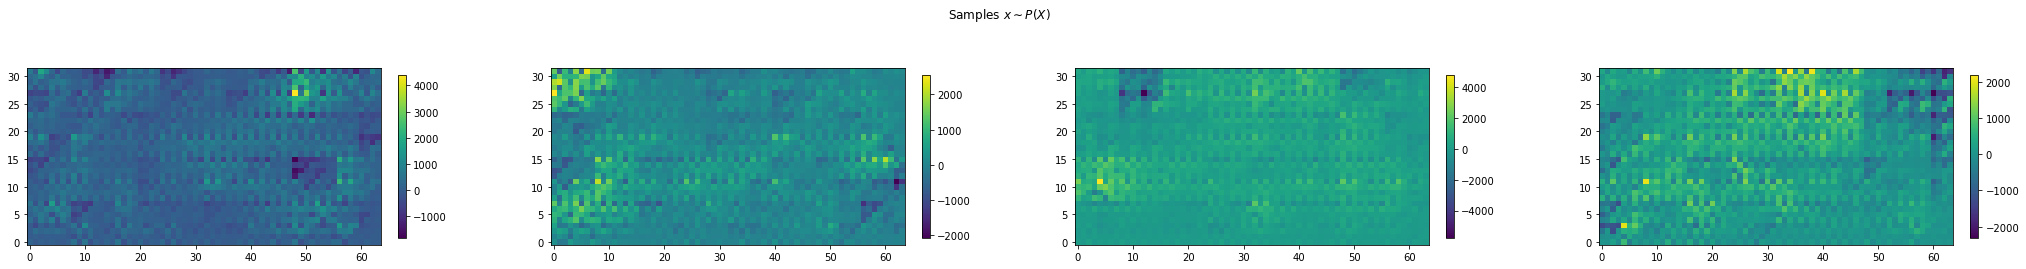

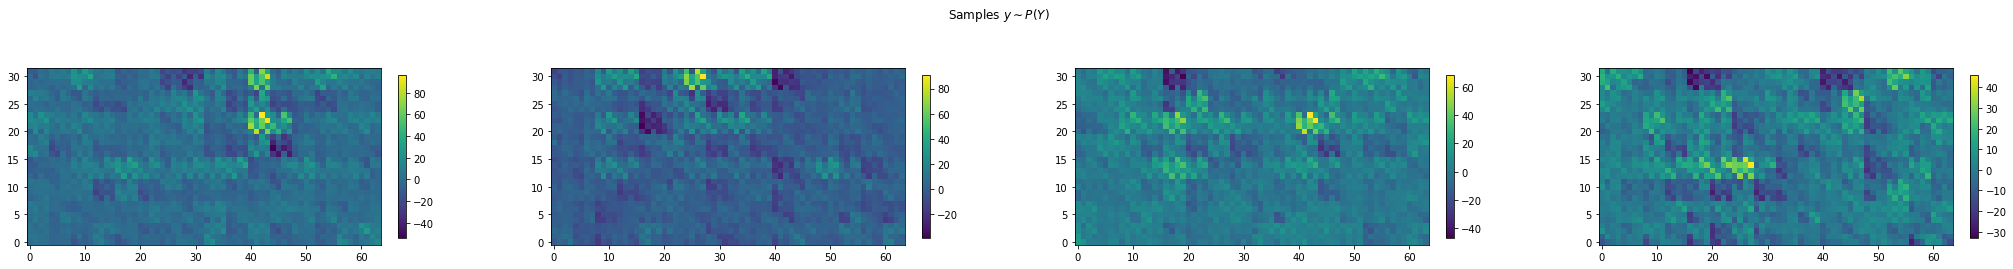

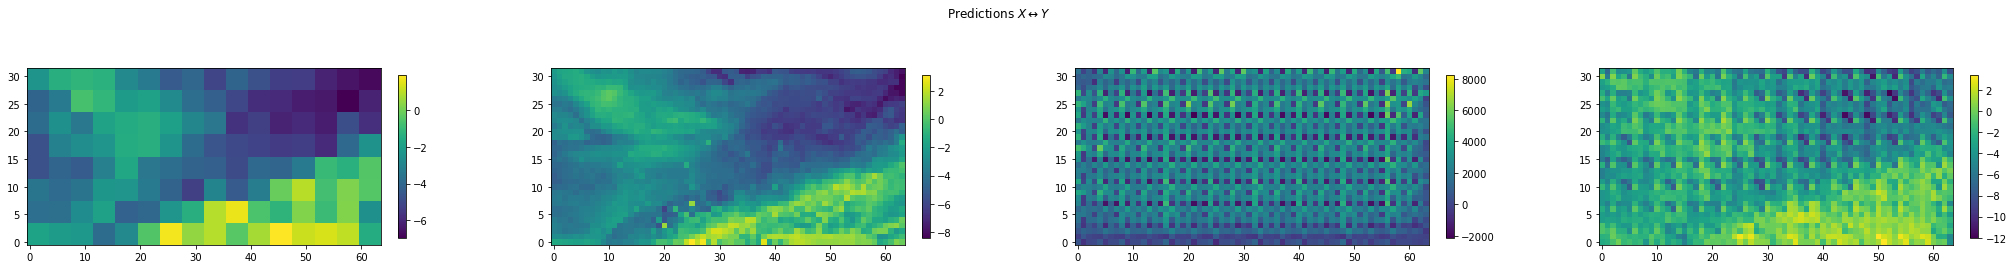

Evaluating ClimDEX indices on predictions
txx bias avg: -0.17483919858932495, std: 1.958336353302002
txn bias avg: 0.2721423804759979, std: 3.2354228496551514


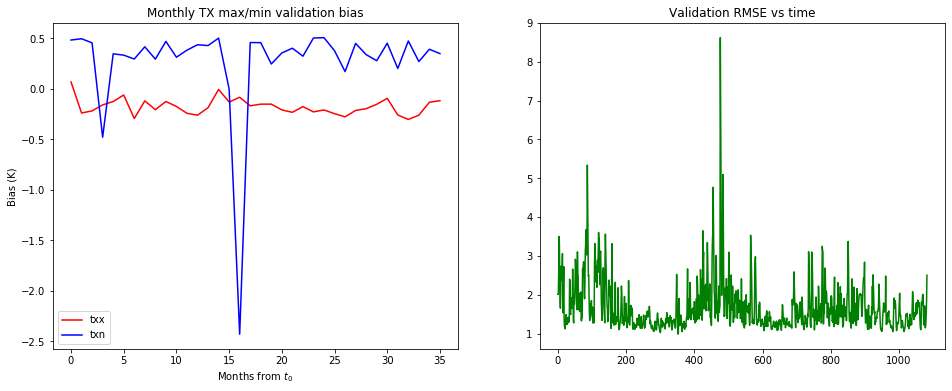

Training joint model for 1 epochs (1/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.55it/s, nll_x=2.74, nll_y=1.82, gx_loss=8.05, gy_loss=0.317, dx_loss=-14.5, dy_loss=0.289, gx_aux=0, gy_aux=0.637]


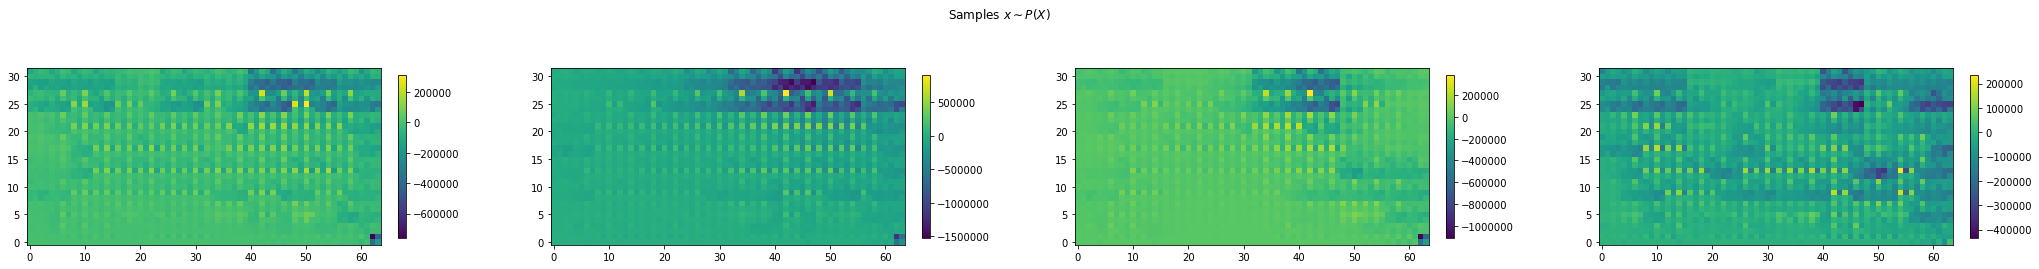

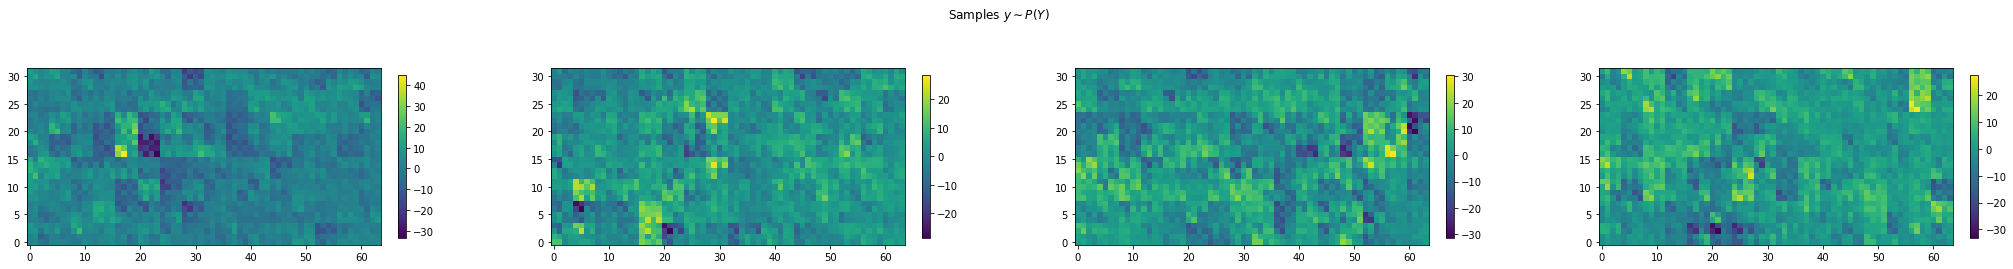

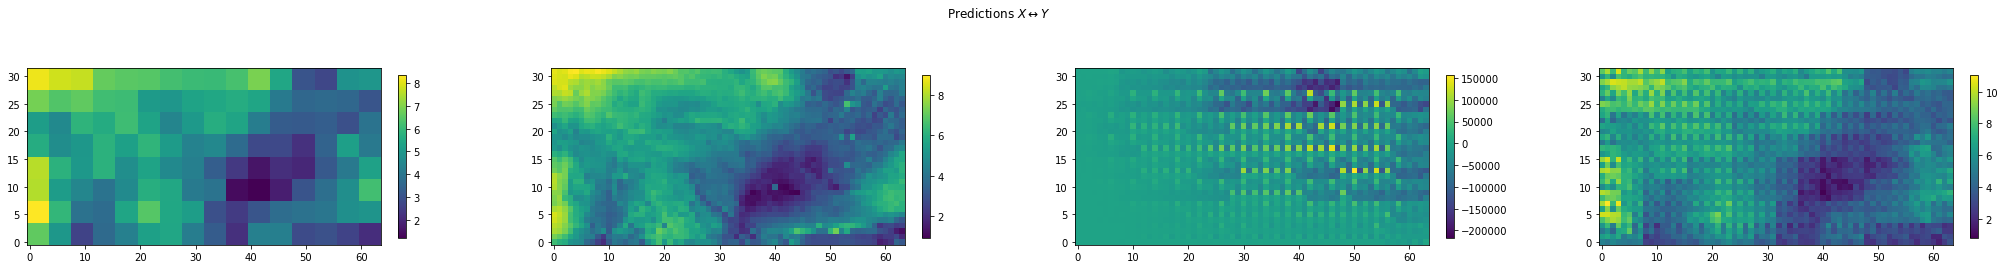

Evaluating ClimDEX indices on predictions
txx bias avg: 0.9779529571533203, std: 1.4242022037506104
txn bias avg: -1.7328503131866455, std: 5.858262062072754


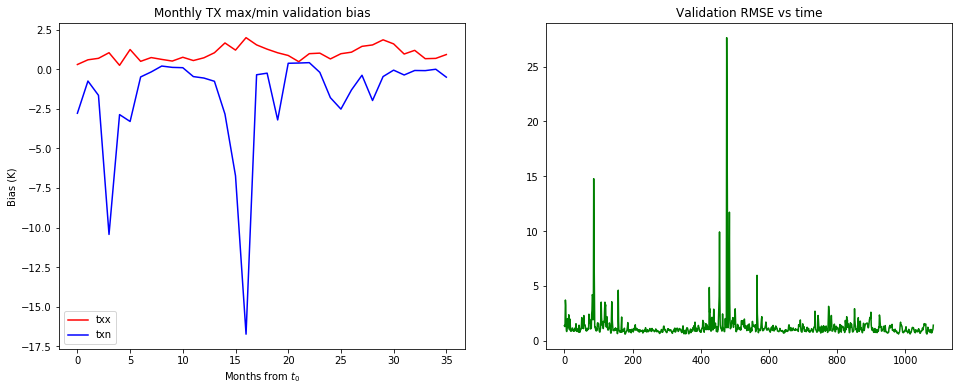

Training joint model for 1 epochs (2/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.59it/s, nll_x=2.55, nll_y=1.87, gx_loss=-23.3, gy_loss=0.537, dx_loss=40.5, dy_loss=0.169, gx_aux=0, gy_aux=0.235]


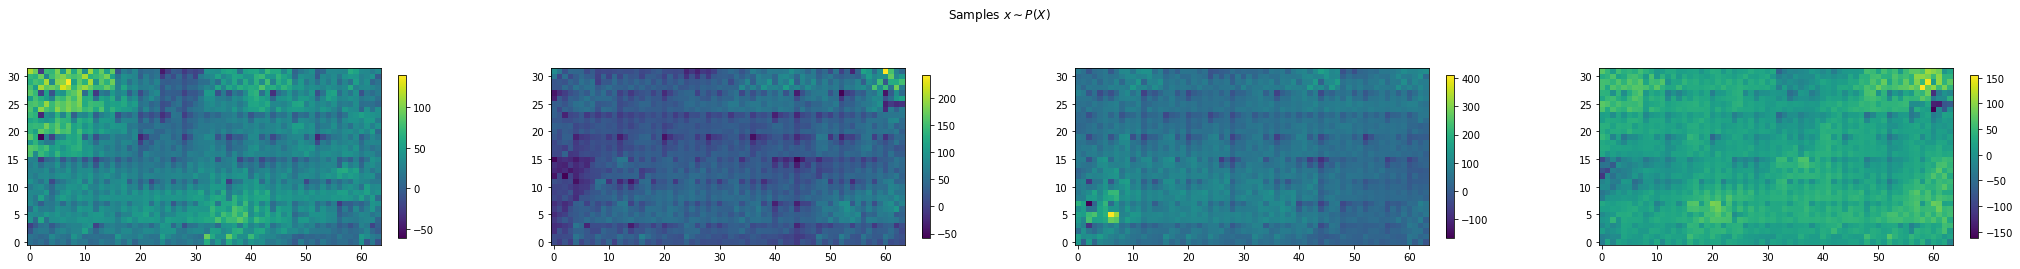

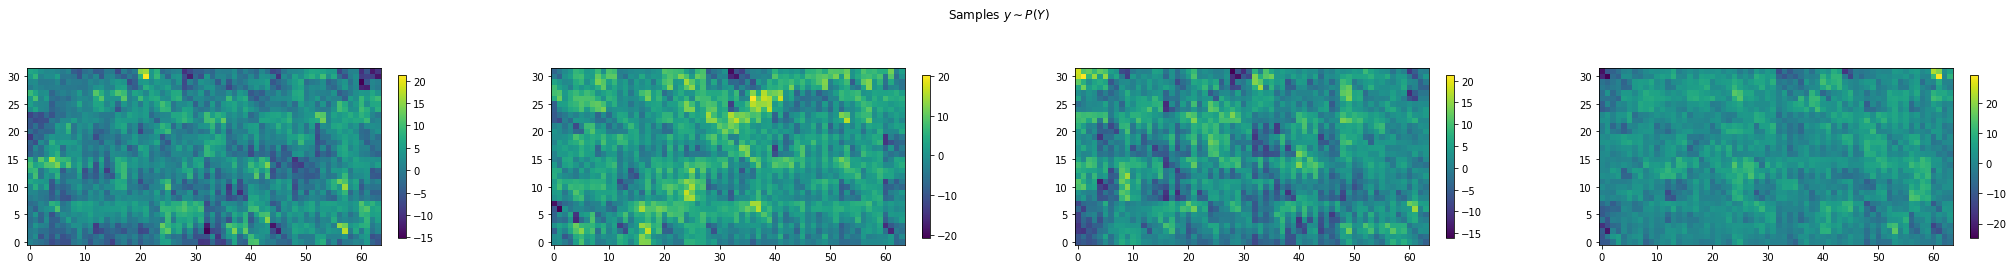

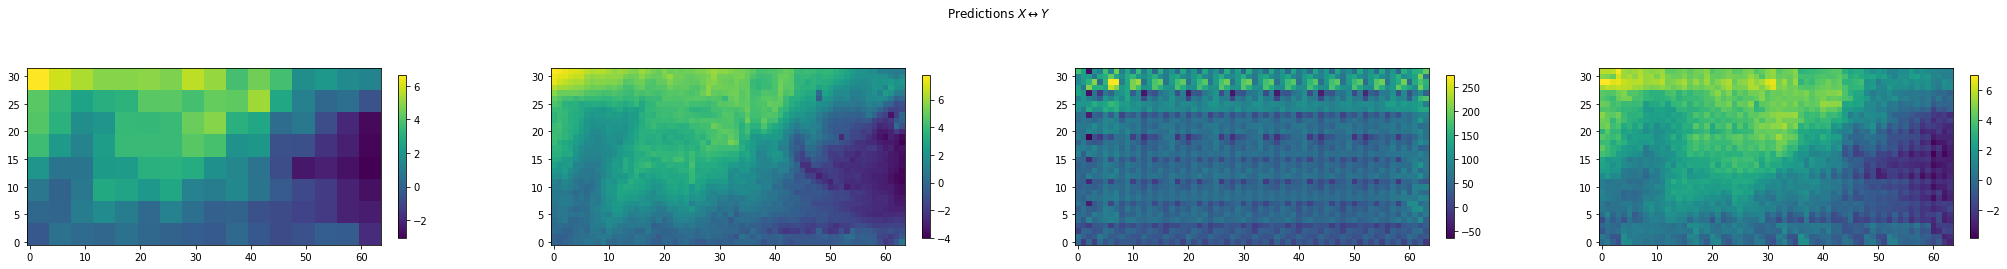

Evaluating ClimDEX indices on predictions
txx bias avg: -0.10008036345243454, std: 0.9080549478530884
txn bias avg: 0.6607018113136292, std: 1.4647420644760132


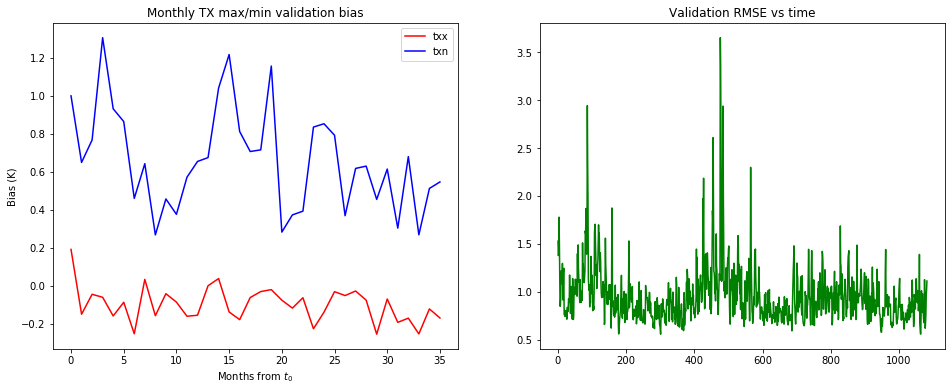

Training joint model for 1 epochs (3/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, nll_x=2.53, nll_y=2.27, gx_loss=16.4, gy_loss=0.836, dx_loss=-33.4, dy_loss=0.0312, gx_aux=0, gy_aux=0.177]


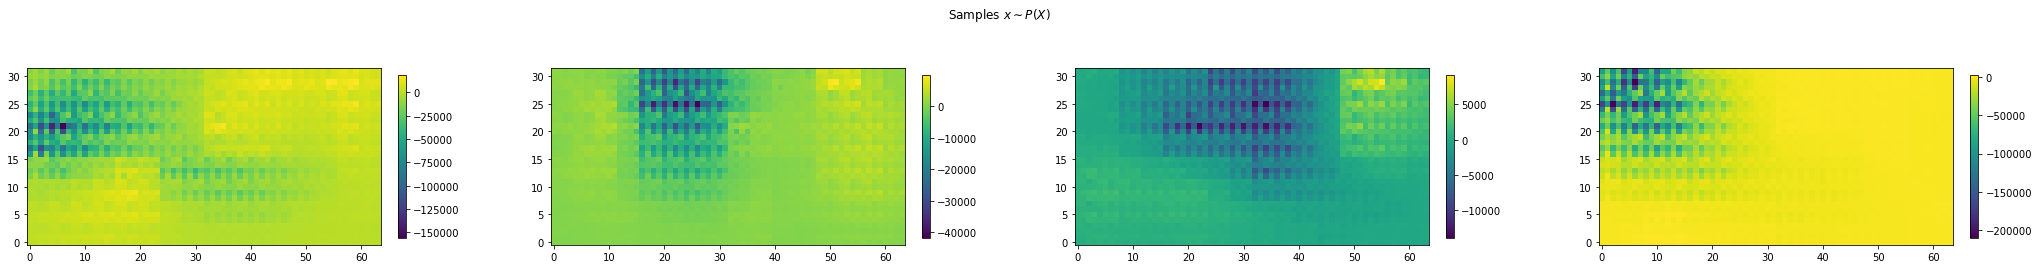

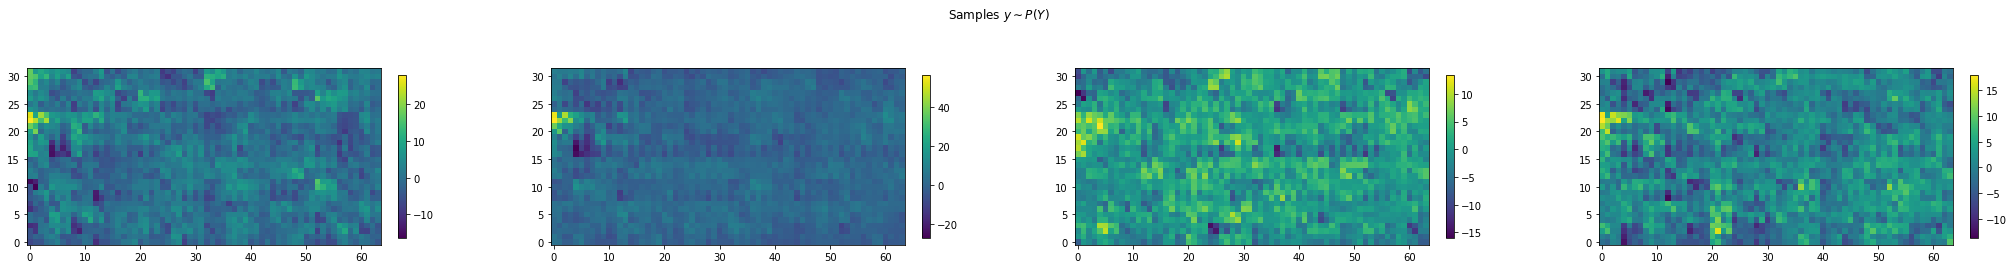

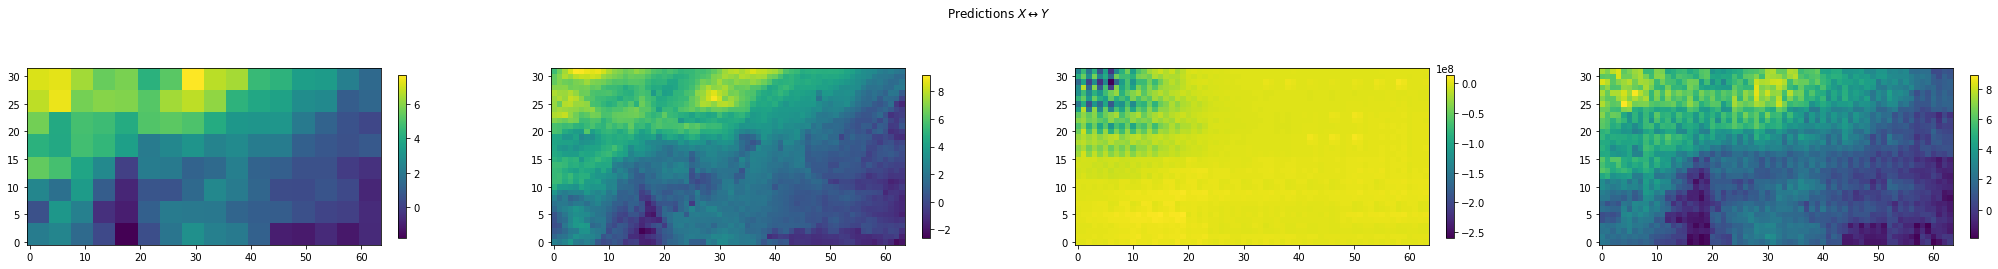

Evaluating ClimDEX indices on predictions
txx bias avg: -0.10219613462686539, std: 1.164844036102295
txn bias avg: -0.03834455460309982, std: 1.6137089729309082


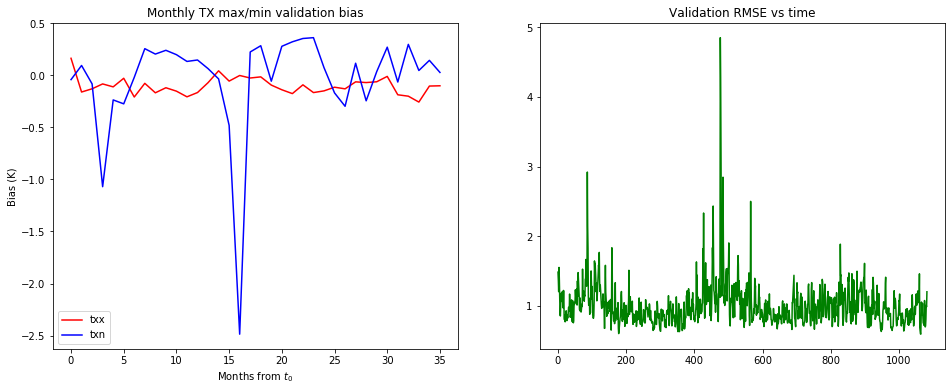

Training joint model for 1 epochs (4/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.48it/s, nll_x=2.4, nll_y=1.77, gx_loss=26.4, gy_loss=1.1, dx_loss=-58.6, dy_loss=-.0896, gx_aux=0, gy_aux=0.229]


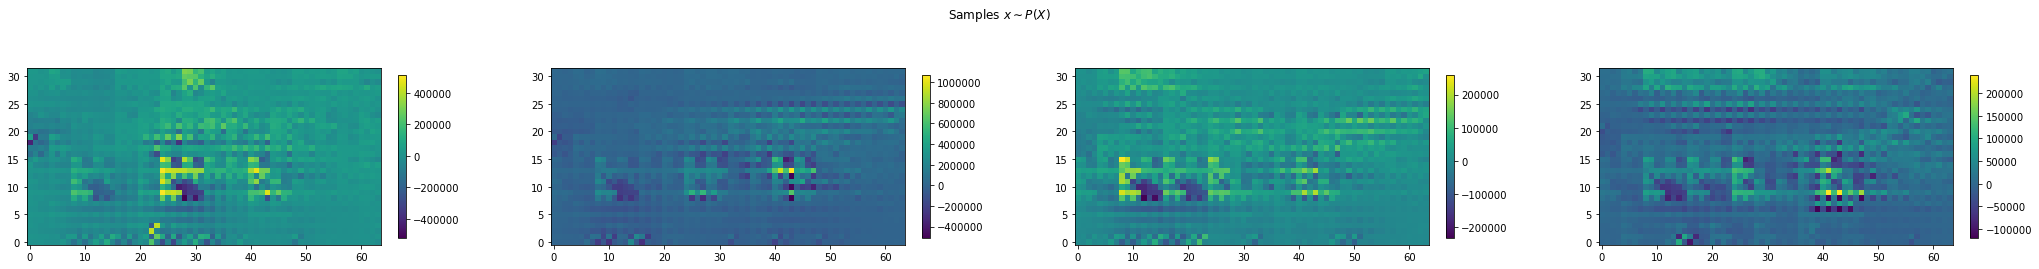

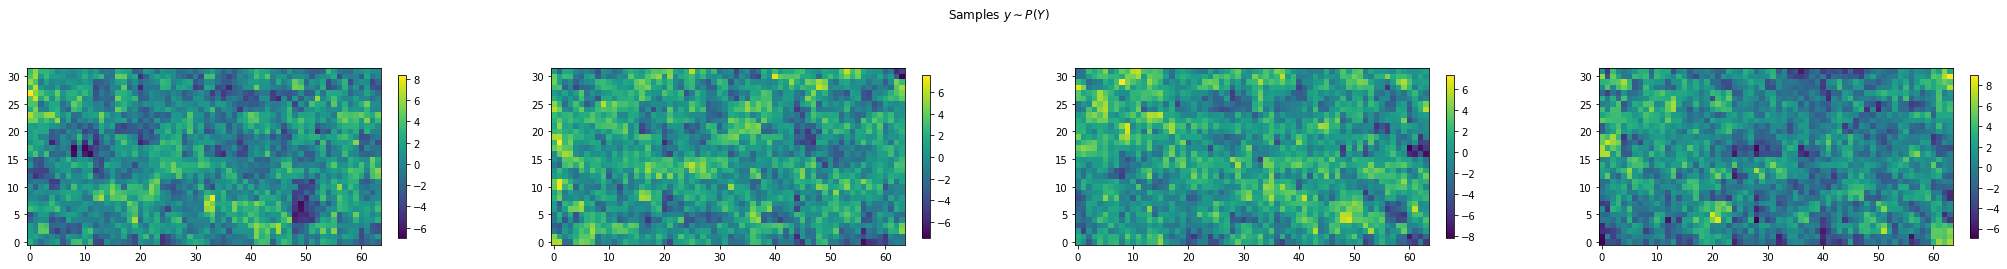

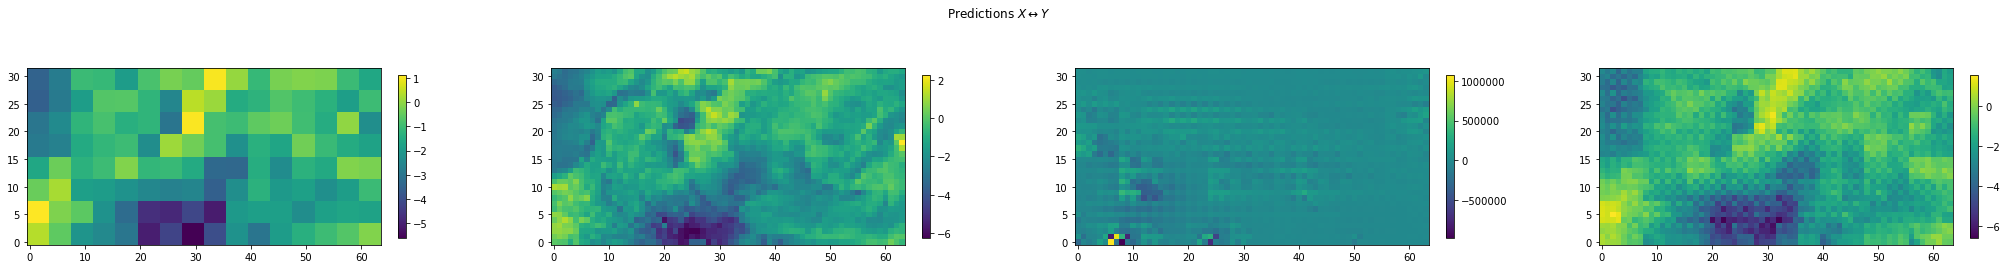

Evaluating ClimDEX indices on predictions
txx bias avg: 0.01135545875877142, std: 1.1171040534973145
txn bias avg: -0.5336925983428955, std: 2.223677158355713


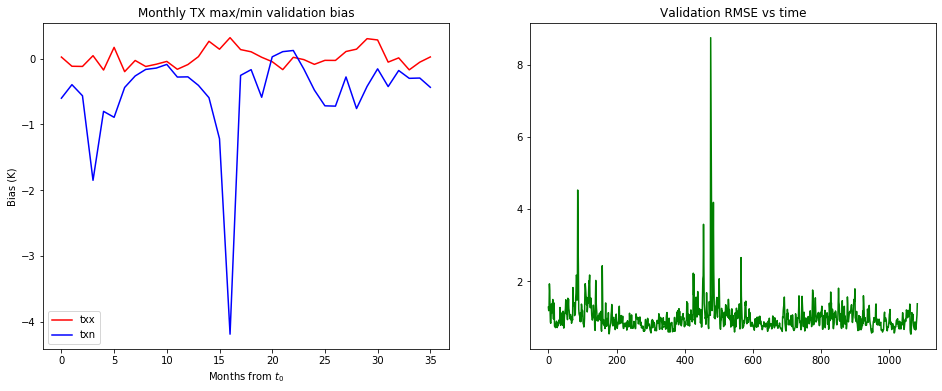

Training joint model for 1 epochs (5/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.48it/s, nll_x=2.01, nll_y=1.56, gx_loss=-35.3, gy_loss=1.06, dx_loss=3.99, dy_loss=-.0294, gx_aux=0, gy_aux=0.225]


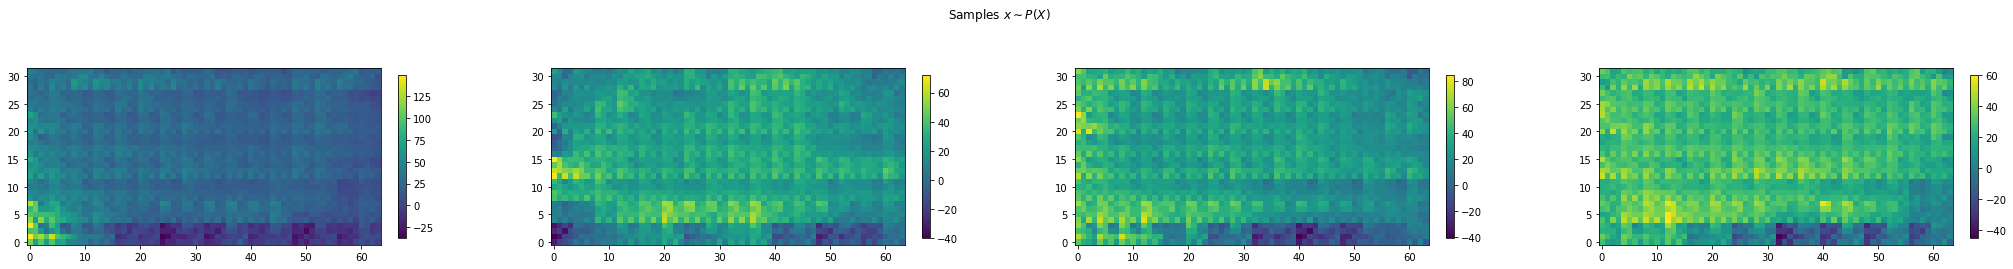

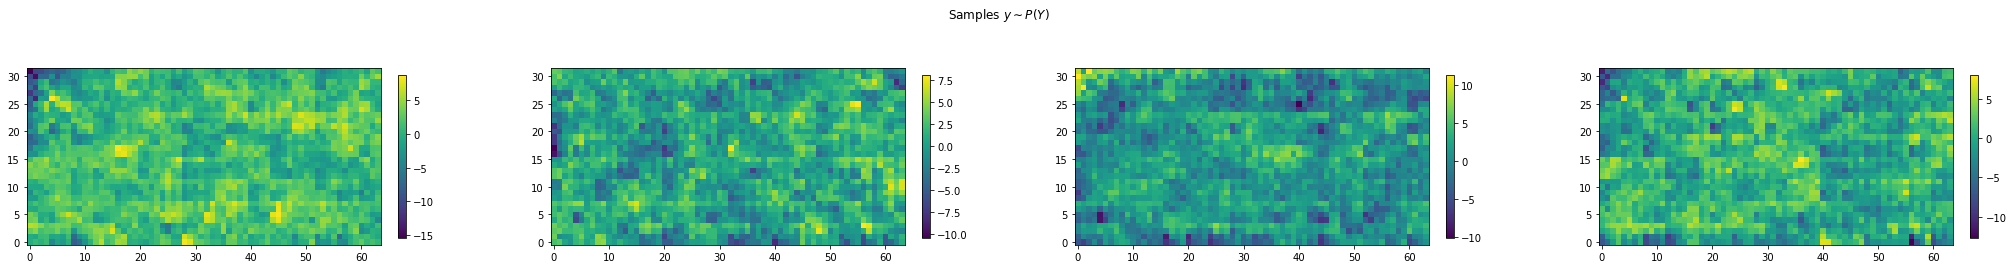

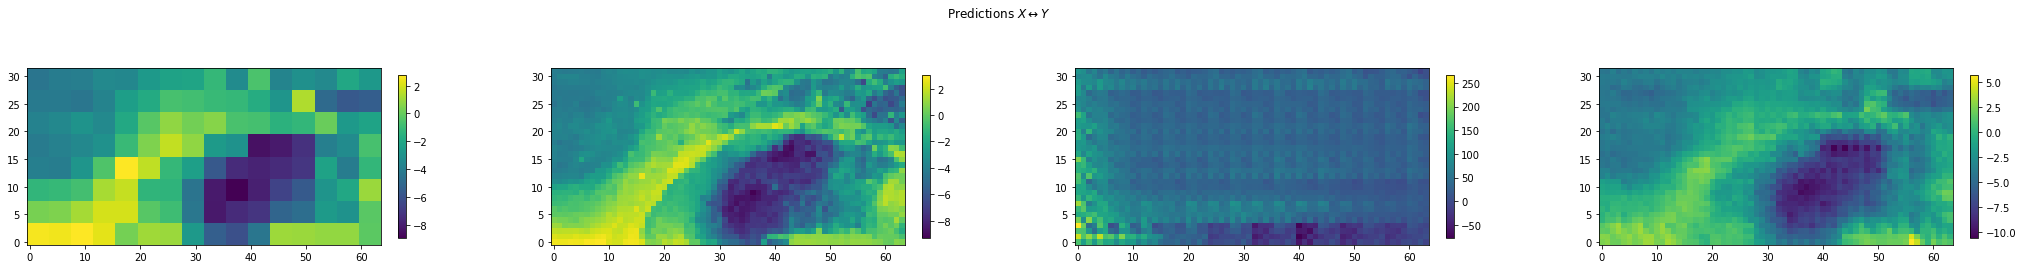

Evaluating ClimDEX indices on predictions
txx bias avg: -0.39610555768013, std: 0.8907799124717712
txn bias avg: -0.31623318791389465, std: 1.4171663522720337


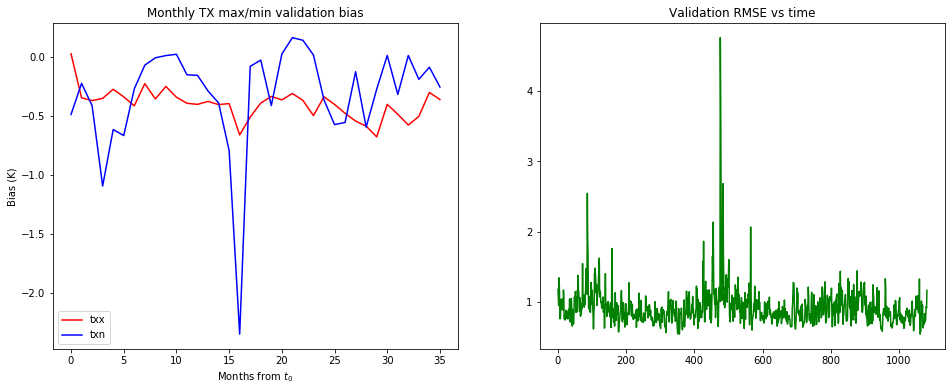

Training joint model for 1 epochs (6/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.57it/s, nll_x=1.49, nll_y=1.48, gx_loss=-31.6, gy_loss=1.2, dx_loss=0.336, dy_loss=-.094, gx_aux=0, gy_aux=0.186] 


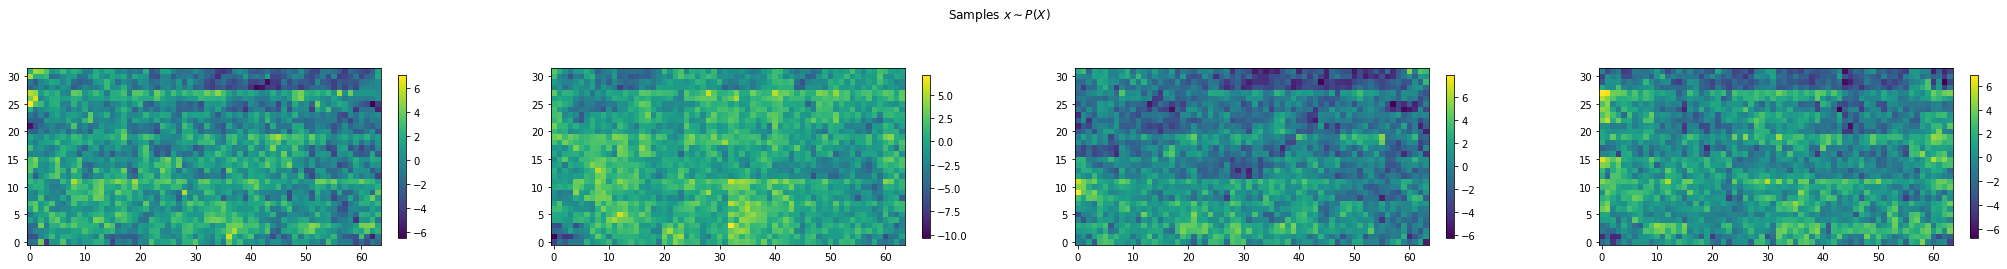

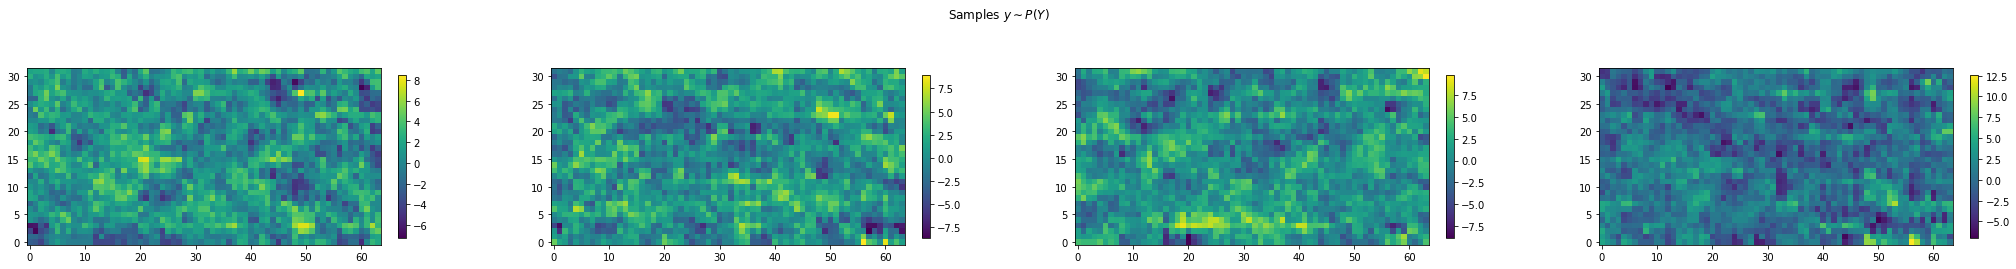

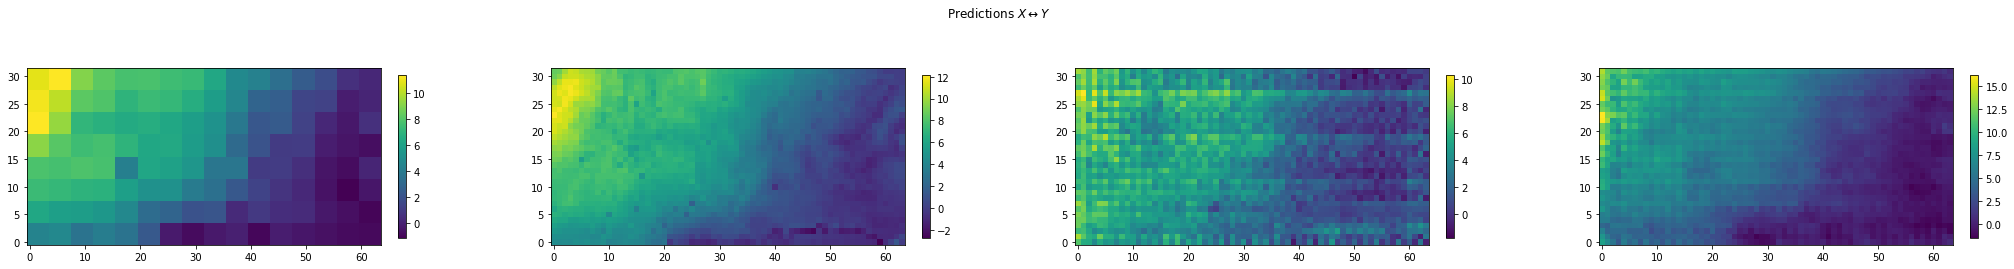

Evaluating ClimDEX indices on predictions
txx bias avg: -0.3552631139755249, std: 0.9618353247642517
txn bias avg: 0.1155318170785904, std: 2.5413196086883545


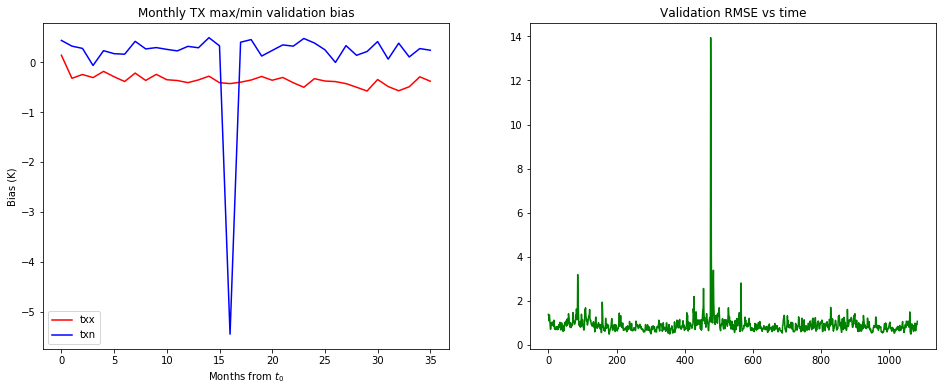

Training joint model for 1 epochs (7/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.52it/s, nll_x=0.973, nll_y=1.43, gx_loss=-29.1, gy_loss=1.2, dx_loss=-.0142, dy_loss=-.0427, gx_aux=0, gy_aux=0.253] 


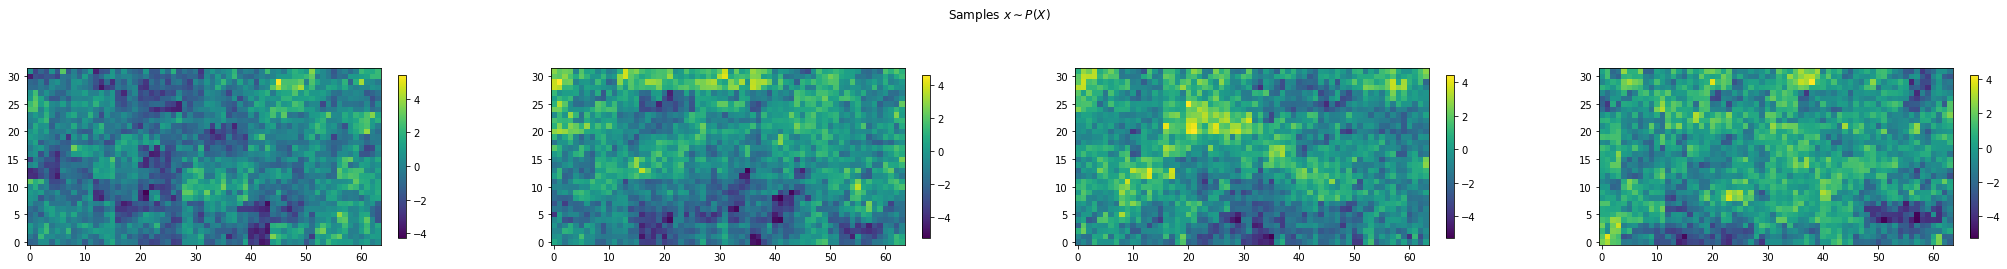

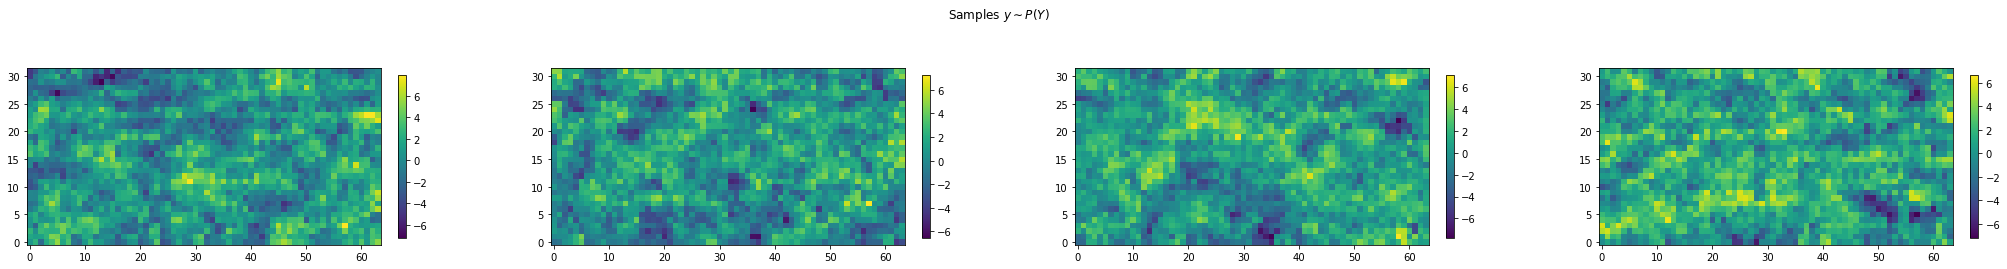

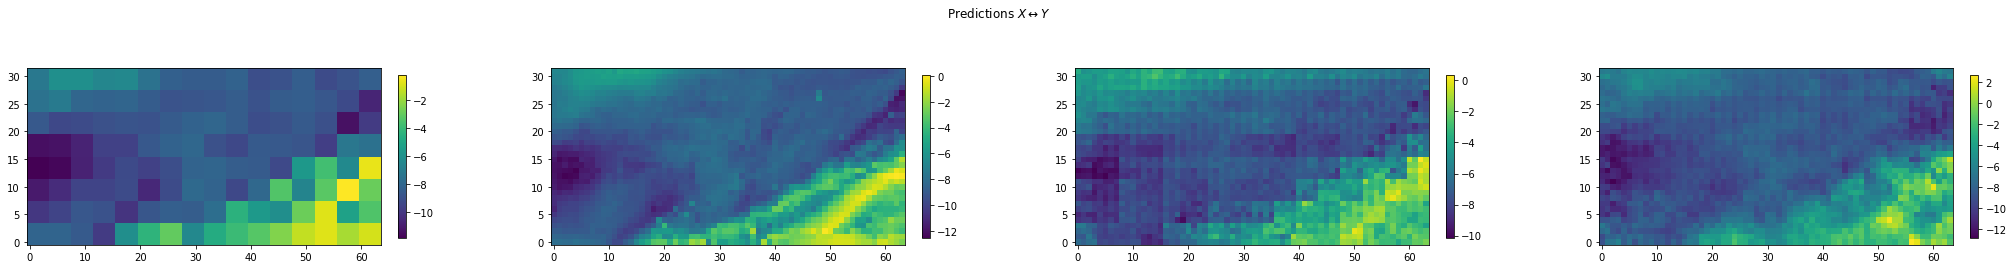

Evaluating ClimDEX indices on predictions
txx bias avg: 0.18125854432582855, std: 0.7872588634490967
txn bias avg: 0.264261394739151, std: 1.112763524055481


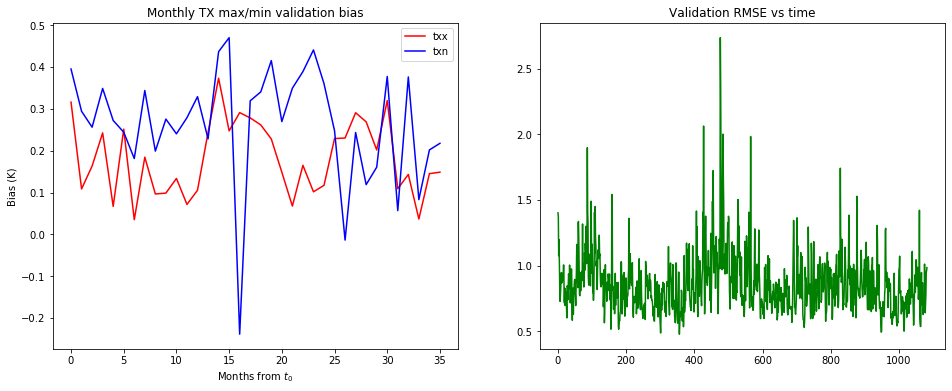

Training joint model for 1 epochs (8/20 complete)


eval: 100%|██████████| 108/108 [00:29<00:00,  3.61it/s, nll_x=0.783, nll_y=1.41, gx_loss=-27.2, gy_loss=1.23, dx_loss=0.0125, dy_loss=-.0864, gx_aux=0, gy_aux=0.186]


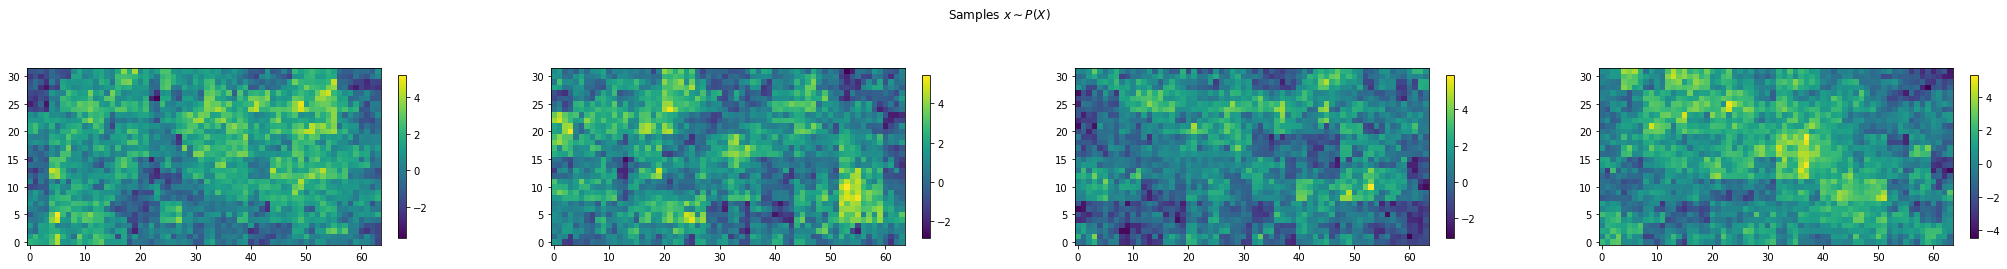

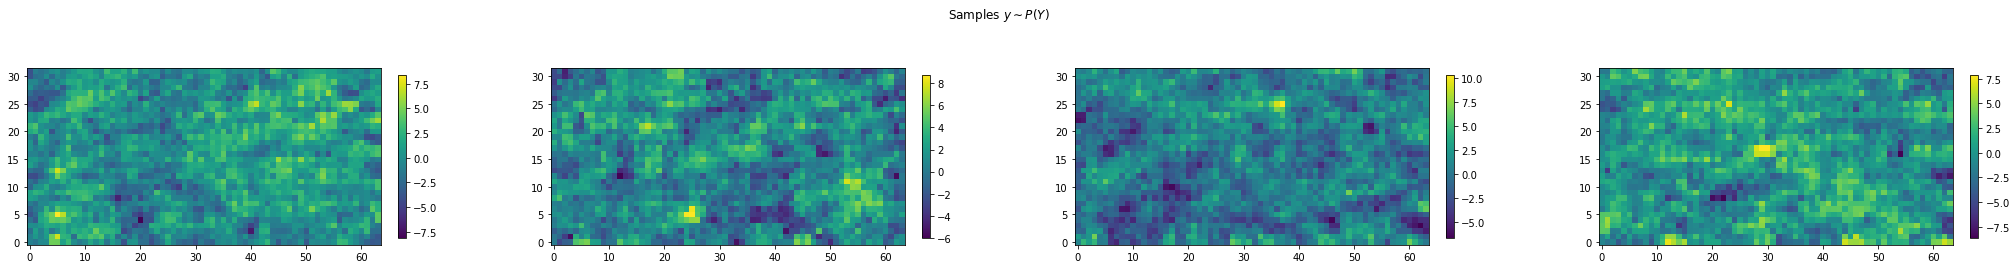

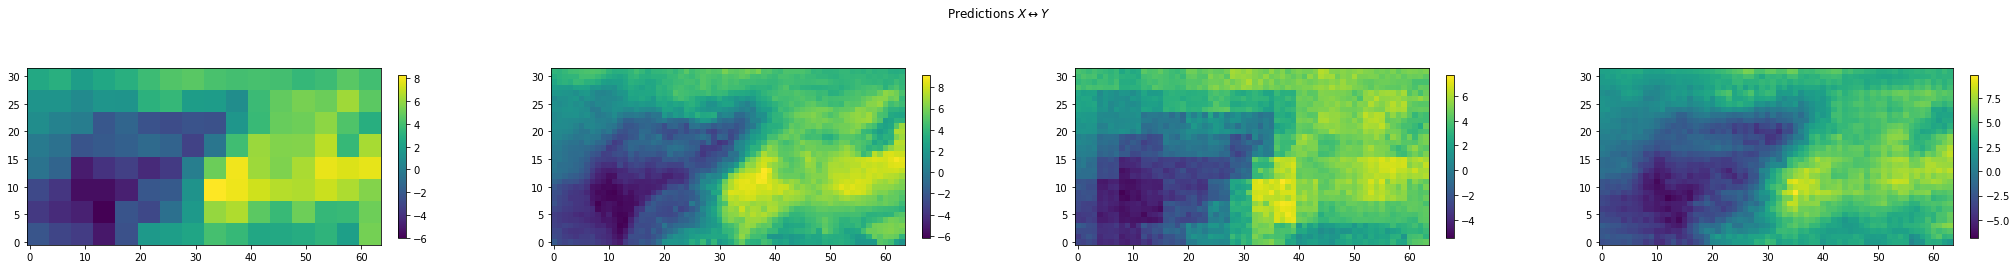

Evaluating ClimDEX indices on predictions
txx bias avg: -0.28567105531692505, std: 0.739954948425293
txn bias avg: -0.2841566503047943, std: 1.361723780632019


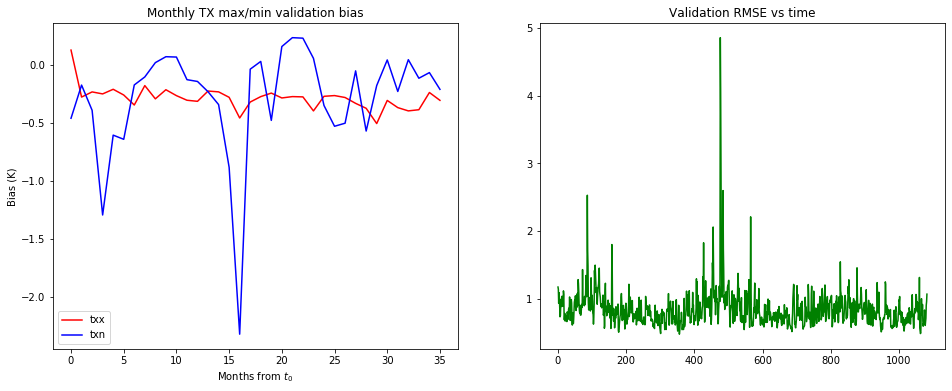

Training joint model for 1 epochs (9/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.54it/s, nll_x=0.612, nll_y=1.37, gx_loss=-25.7, gy_loss=1.25, dx_loss=-.0859, dy_loss=-.0975, gx_aux=0, gy_aux=0.201]


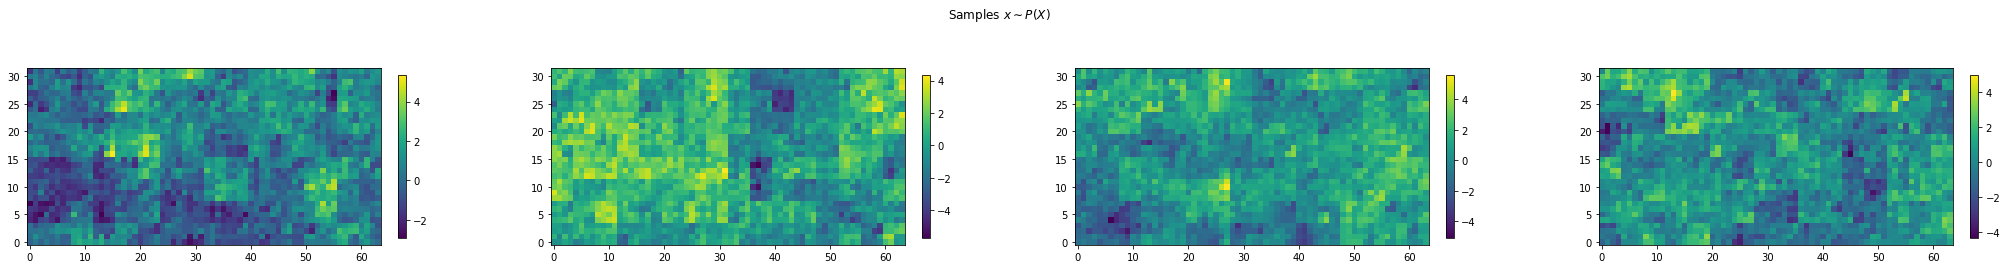

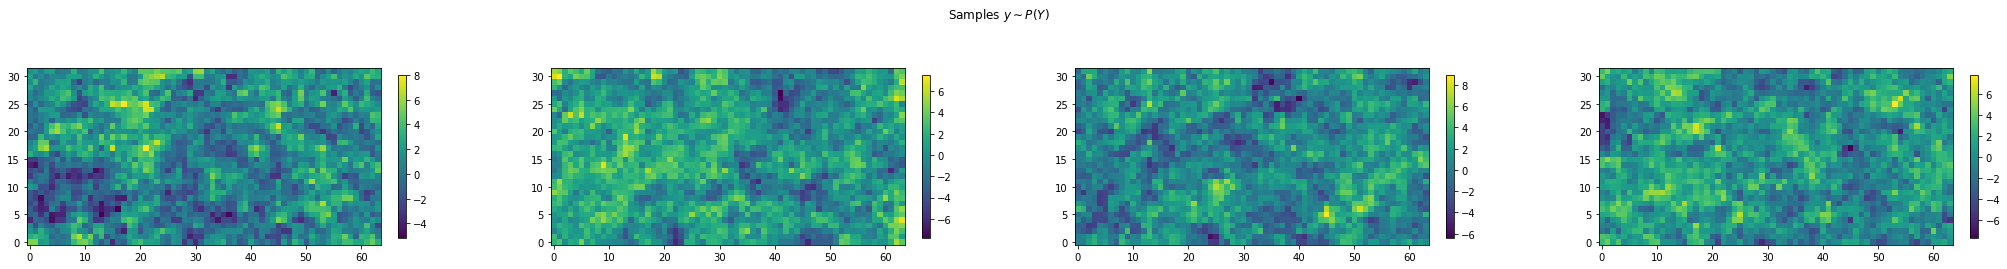

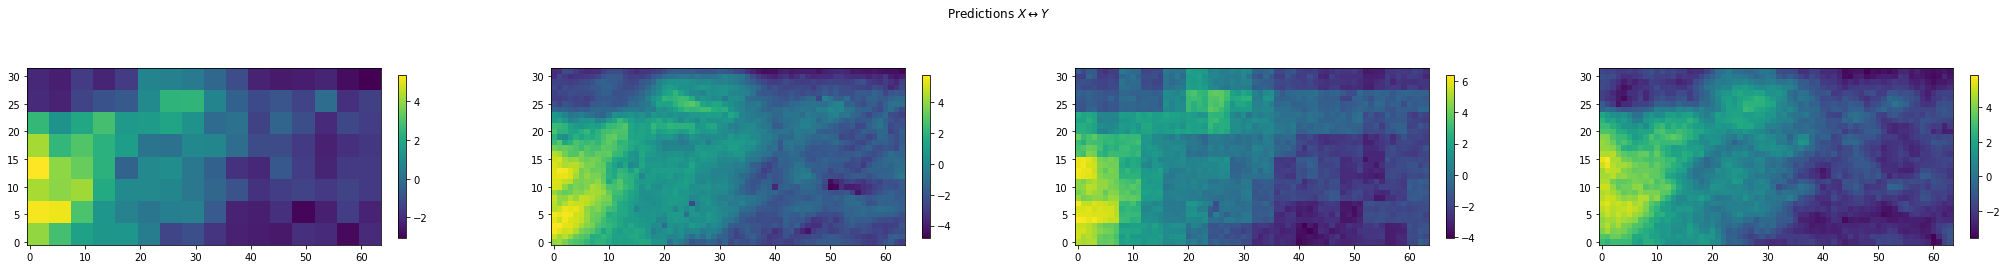

Evaluating ClimDEX indices on predictions
txx bias avg: -0.28980615735054016, std: 0.6862674355506897
txn bias avg: -0.40176835656166077, std: 1.3710503578186035


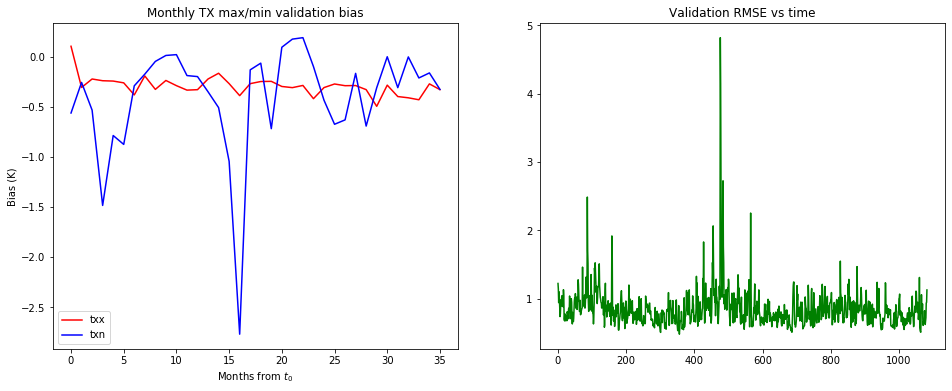

Training joint model for 1 epochs (10/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.50it/s, nll_x=0.473, nll_y=1.39, gx_loss=-24.5, gy_loss=1.39, dx_loss=-.0492, dy_loss=-.0799, gx_aux=0, gy_aux=0.221]


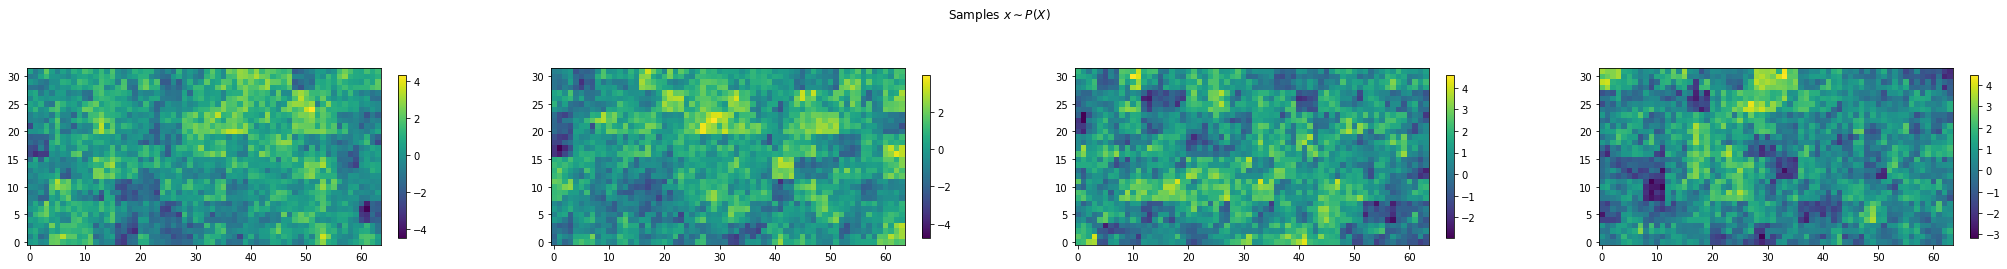

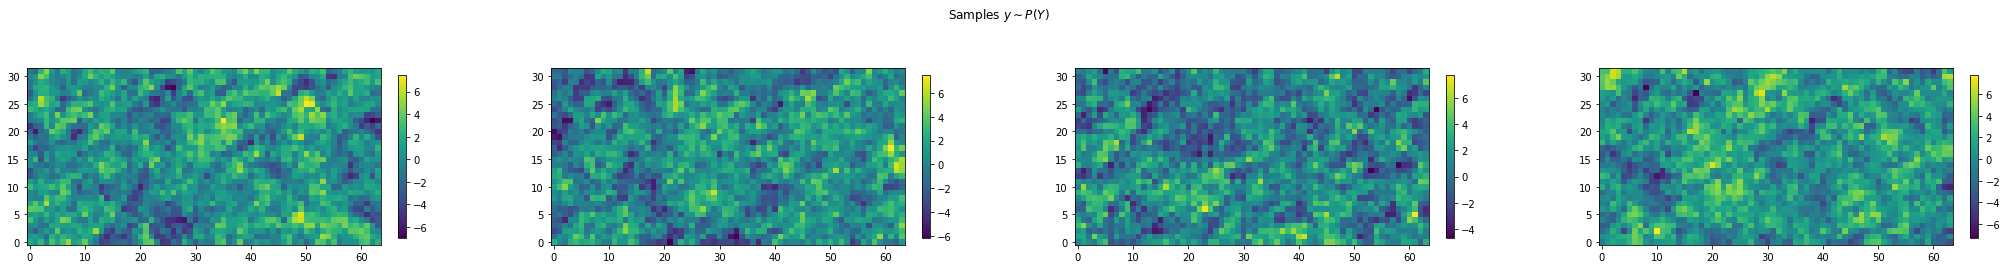

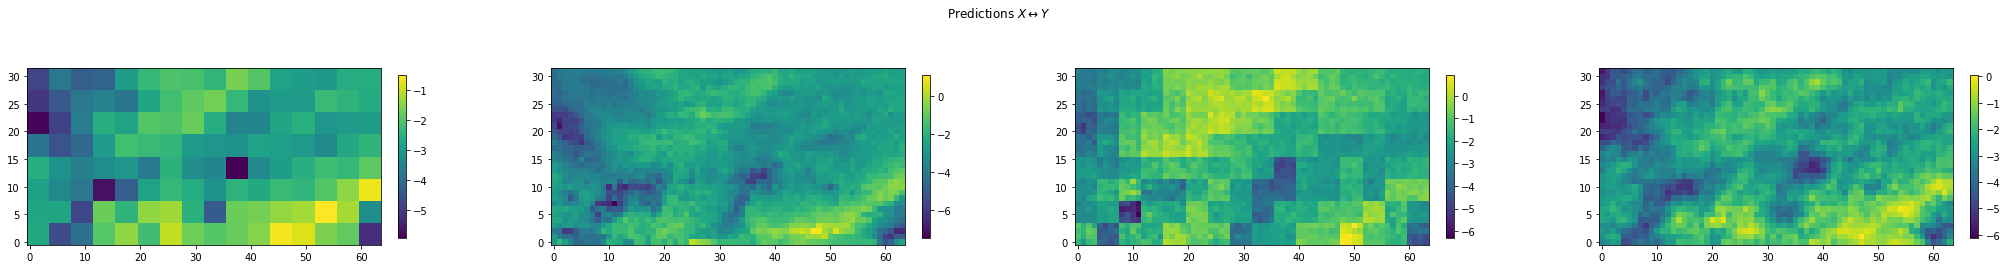

Evaluating ClimDEX indices on predictions
txx bias avg: 0.052951257675886154, std: 0.6879342198371887
txn bias avg: 0.2310769259929657, std: 1.061812162399292


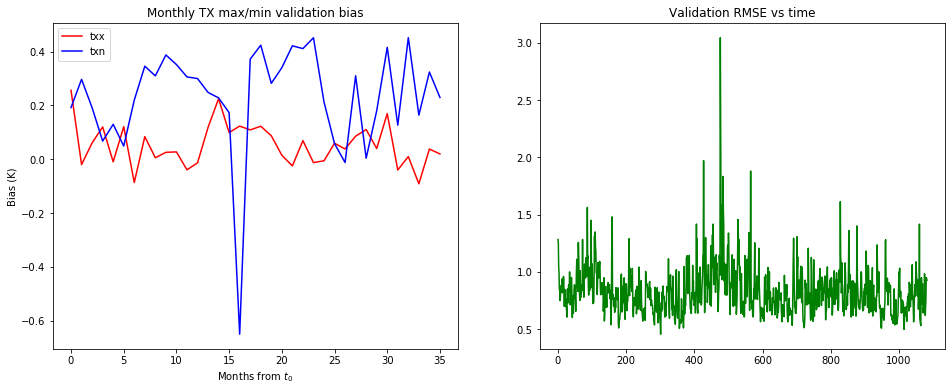

Training joint model for 1 epochs (11/20 complete)


eval: 100%|██████████| 108/108 [00:31<00:00,  3.45it/s, nll_x=0.354, nll_y=1.41, gx_loss=-23.6, gy_loss=1.44, dx_loss=-.00997, dy_loss=-.0733, gx_aux=0, gy_aux=0.162]


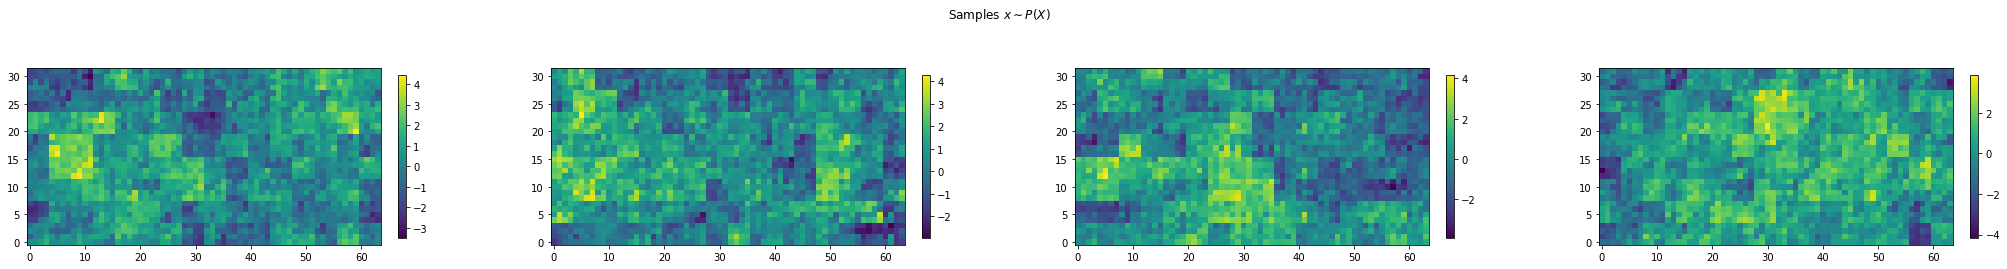

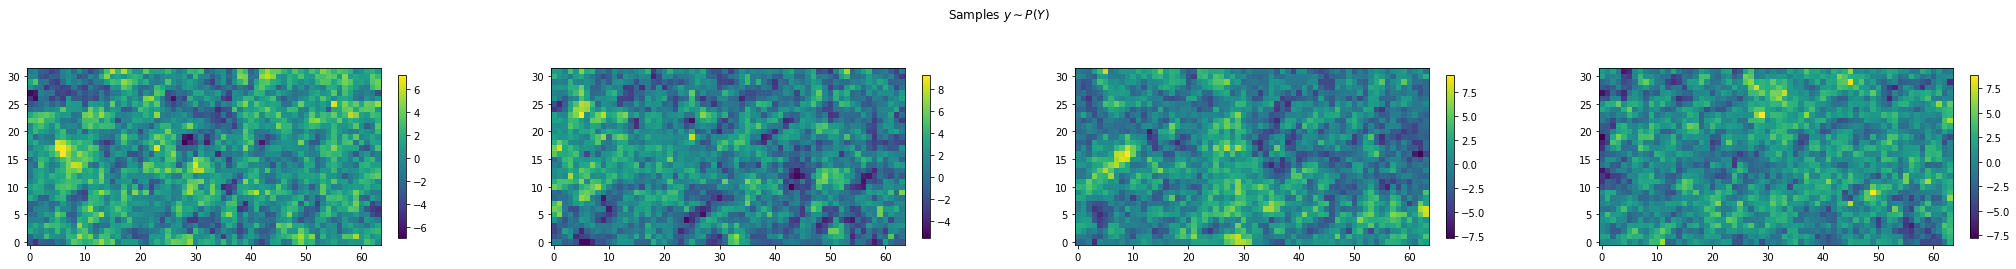

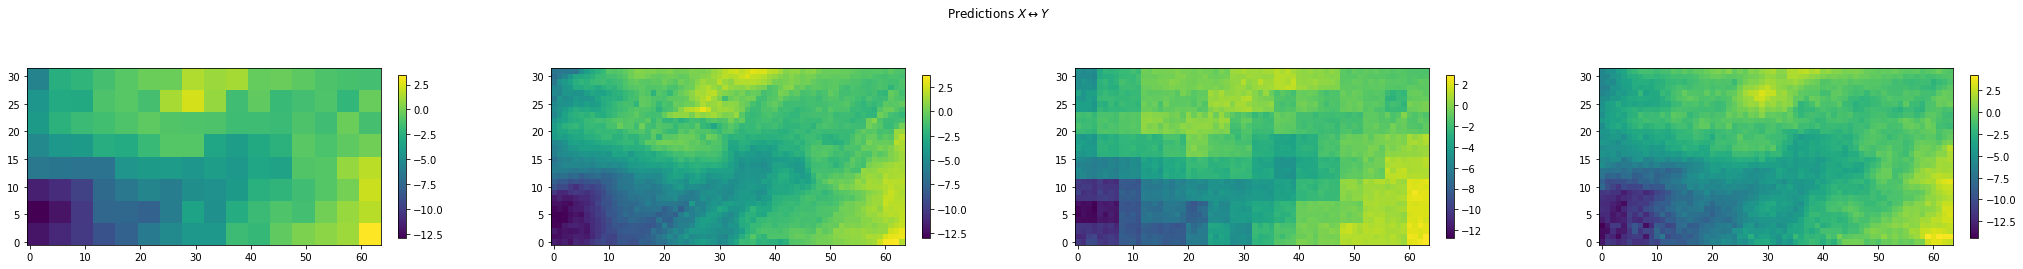

Evaluating ClimDEX indices on predictions
txx bias avg: -0.12766623497009277, std: 0.7539007663726807
txn bias avg: 0.018154118210077286, std: 2.5254955291748047


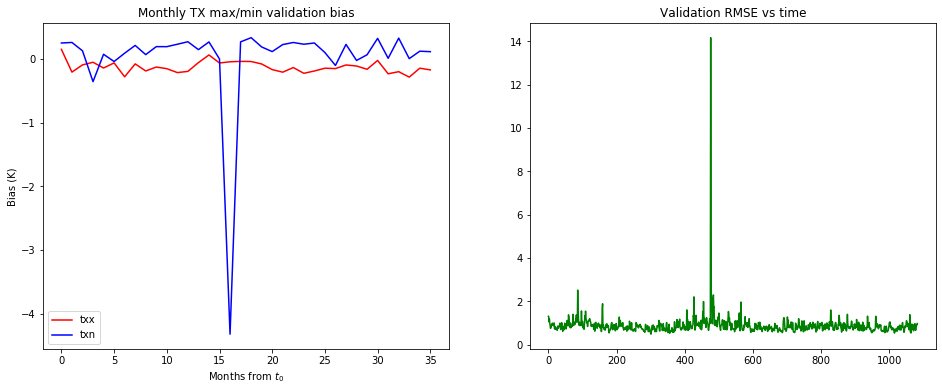

Training joint model for 1 epochs (12/20 complete)


eval: 100%|██████████| 108/108 [00:31<00:00,  3.42it/s, nll_x=0.254, nll_y=1.42, gx_loss=-22.9, gy_loss=1.52, dx_loss=-.00951, dy_loss=-.0686, gx_aux=0, gy_aux=0.212]


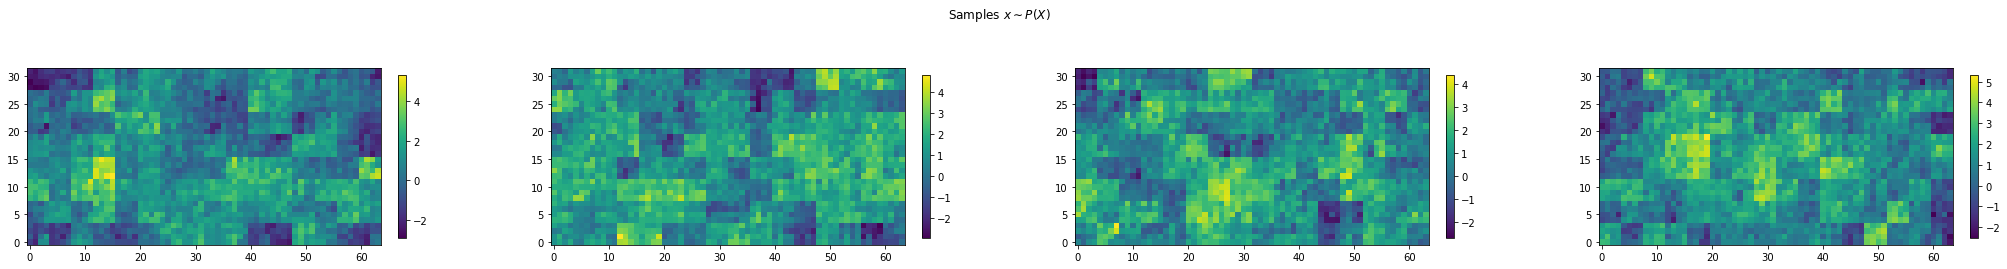

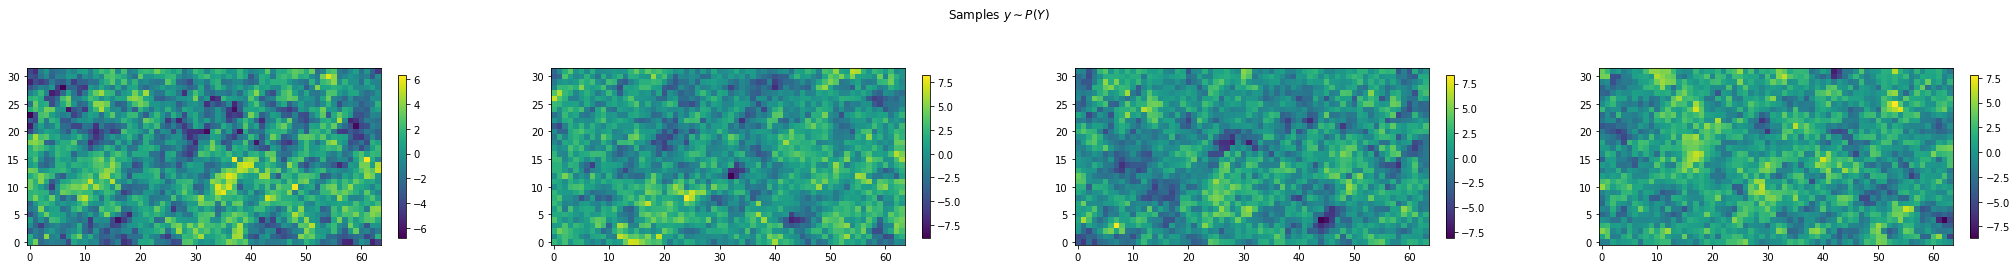

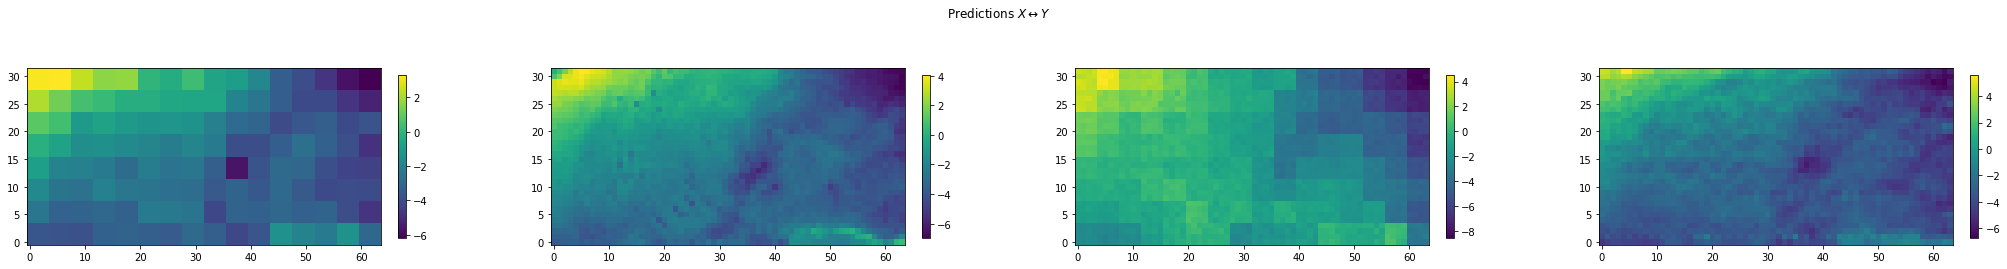

Evaluating ClimDEX indices on predictions
txx bias avg: 0.26900431513786316, std: 0.8699983954429626
txn bias avg: 0.096082903444767, std: 1.044215440750122


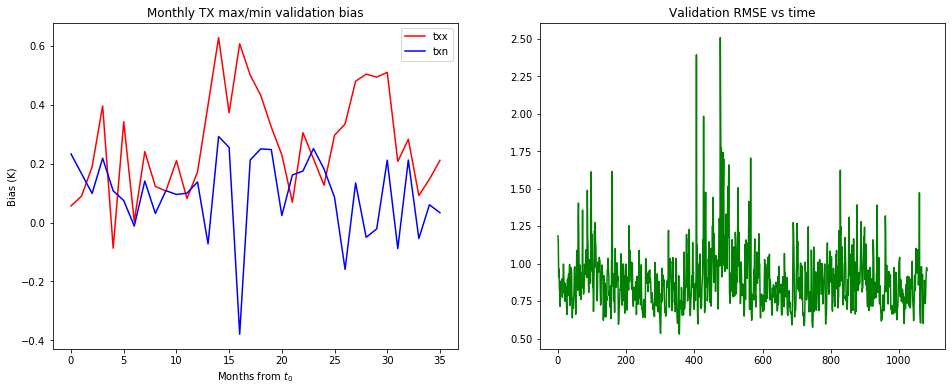

Training joint model for 1 epochs (13/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.58it/s, nll_x=0.131, nll_y=1.44, gx_loss=-22.2, gy_loss=1.48, dx_loss=-.00613, dy_loss=-.0542, gx_aux=0, gy_aux=0.183]


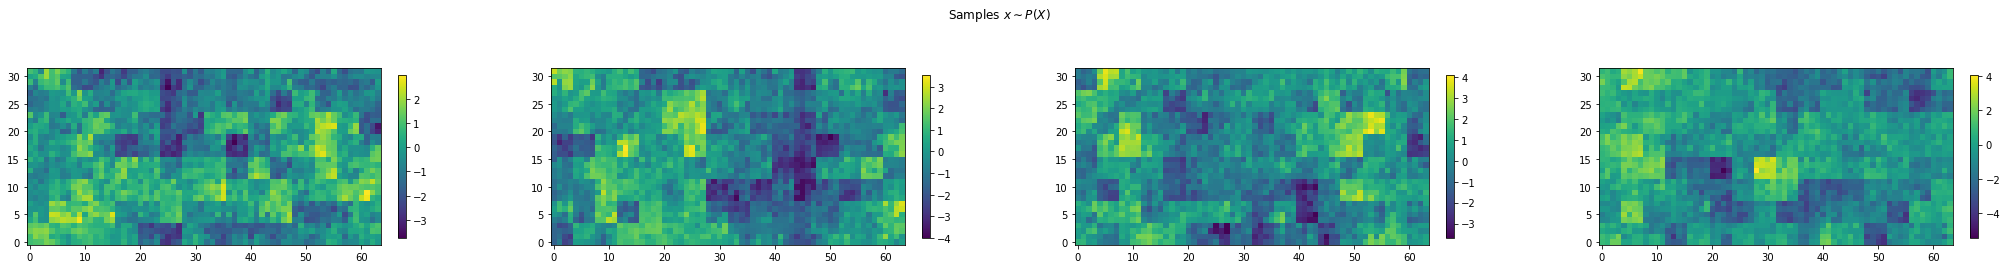

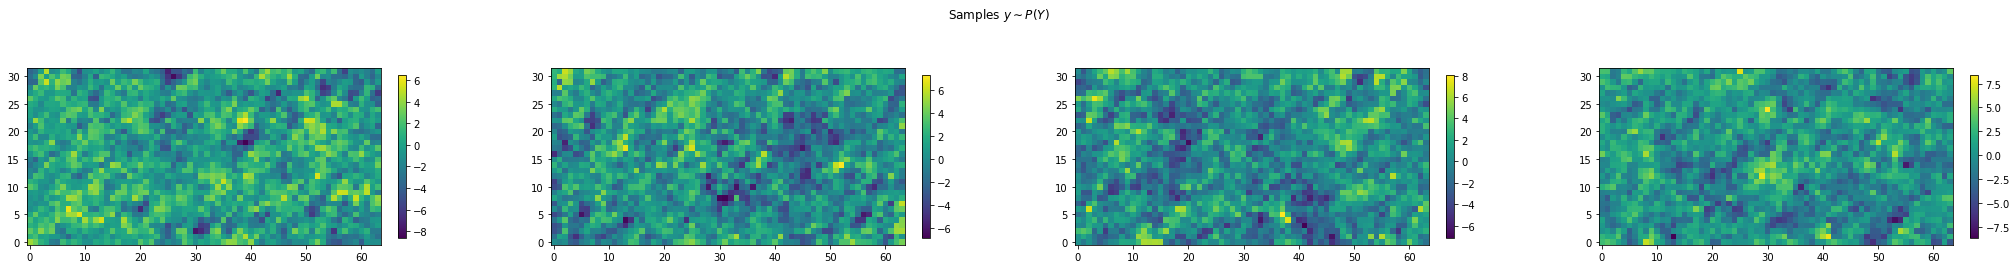

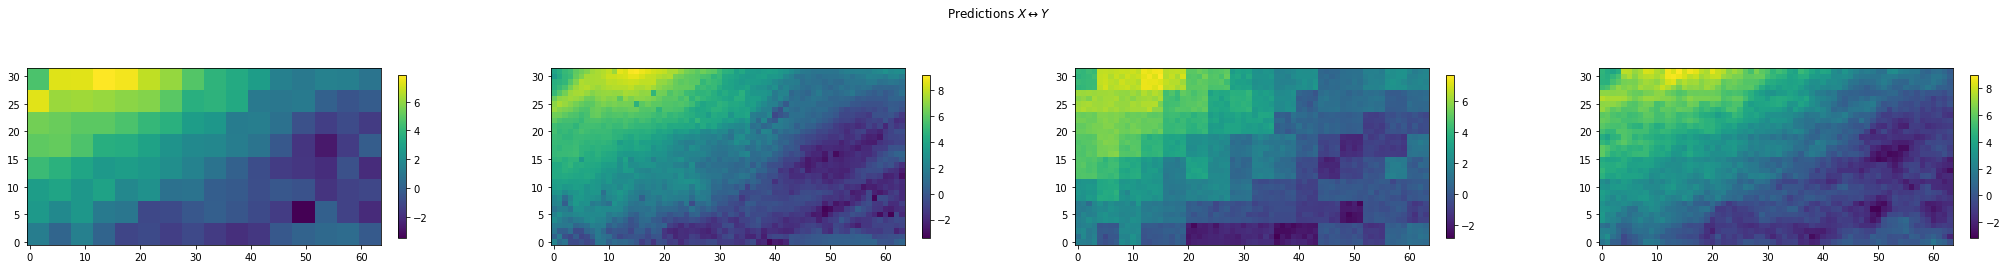

Evaluating ClimDEX indices on predictions
txx bias avg: -0.10332513600587845, std: 0.8839283585548401
txn bias avg: 0.34108930826187134, std: 2.2842392921447754


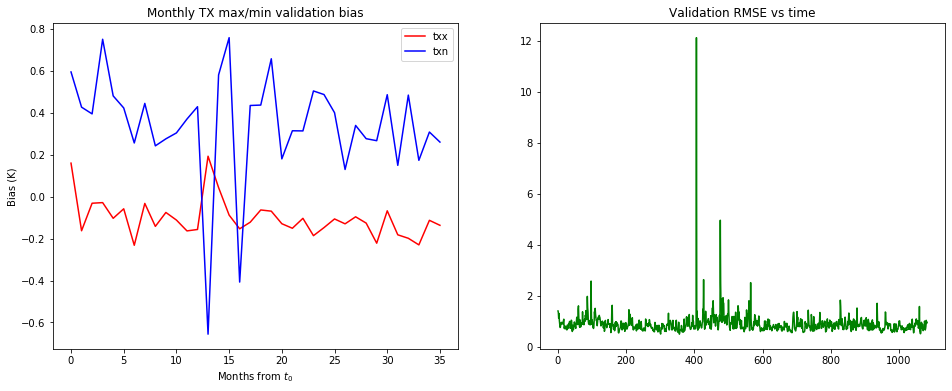

Training joint model for 1 epochs (14/20 complete)


eval: 100%|██████████| 108/108 [00:30<00:00,  3.54it/s, nll_x=0.0237, nll_y=1.43, gx_loss=-21.7, gy_loss=1.59, dx_loss=-.00415, dy_loss=-.0724, gx_aux=0, gy_aux=0.168] 


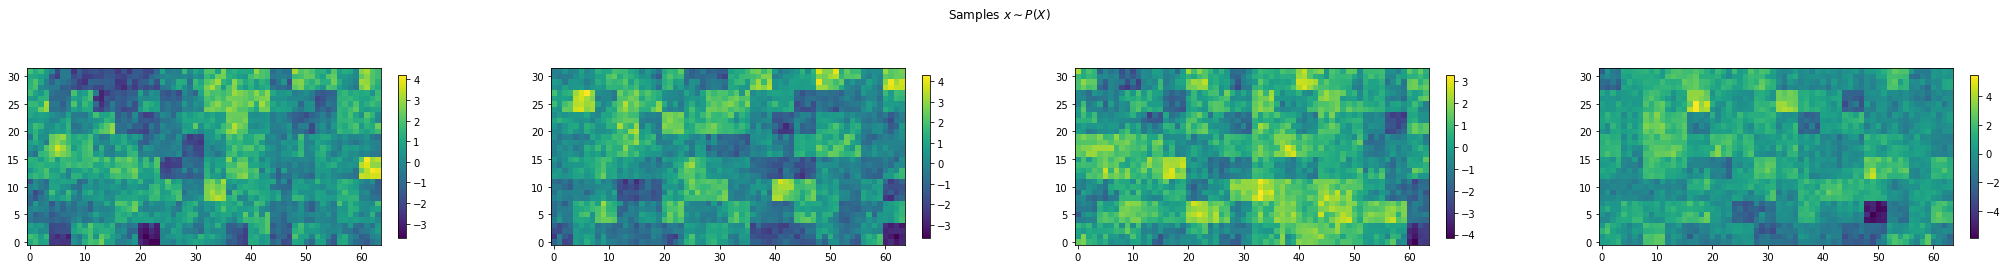

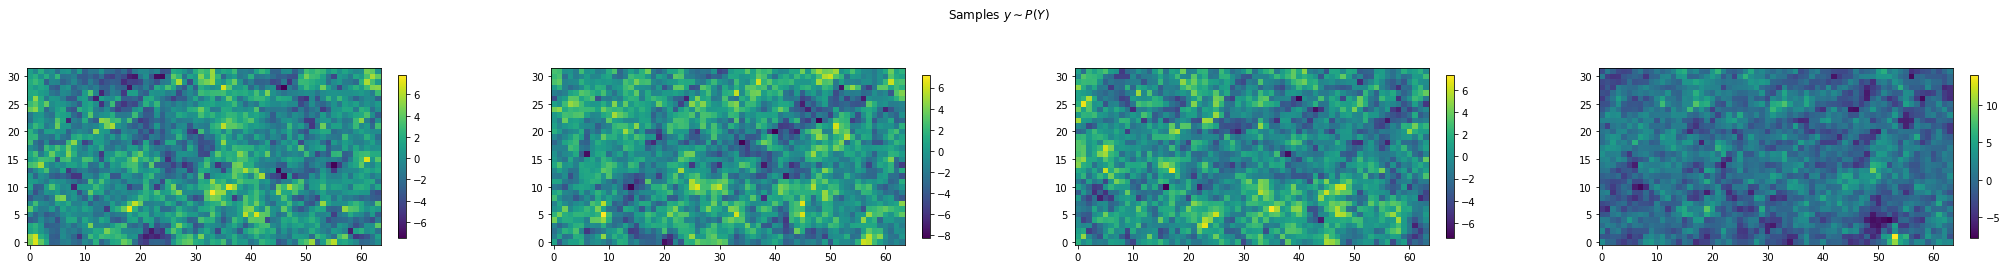

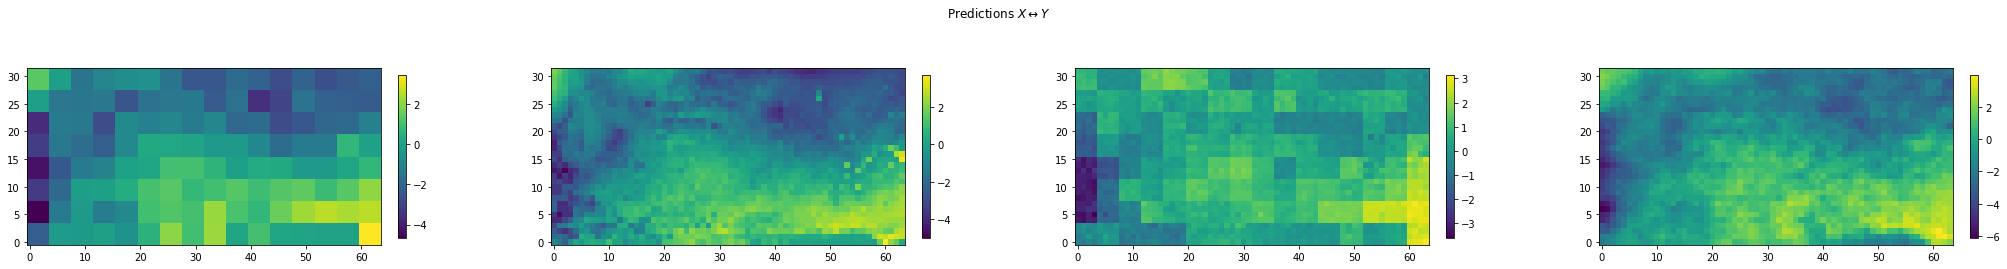

Evaluating ClimDEX indices on predictions
txx bias avg: -0.11059673875570297, std: 0.7311558723449707
txn bias avg: -0.10139192640781403, std: 1.2940781116485596


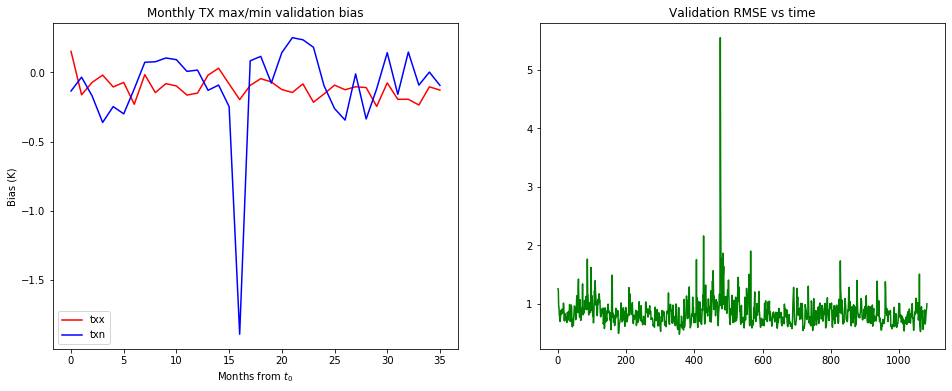

Training joint model for 1 epochs (15/20 complete)


train (D and G):   9%|▉         | 30/330 [00:39<06:30,  1.30s/it, g_obj=-19.6, dx_loss=-.0139, dy_loss=-.0724, nll_x=0.00182, nll_y=1.41]  


KeyboardInterrupt: 

In [9]:
mlflow.set_experiment('scratch')
with mlflow.start_run() as run:
    model = fit_glow_jflvm(folds[-1], layers=4, depth=8, lam=0.1, alpha=0.0, critic_pre_train_steps=0, n_epochs=20)

Fold 1/3
1100 training samples, 1100 test samples, 8x16 -> 32x64


test, epoch 20/20: 100%|██████████| 110/110 [00:07<00:00, 13.94it/s, nll=1.81]


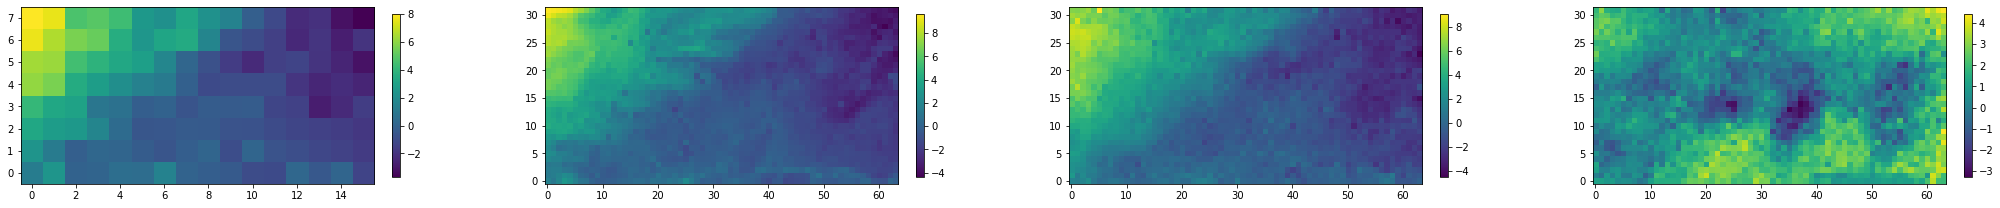

Fold 2/3
2200 training samples, 2200 test samples, 8x16 -> 32x64


test, epoch 20/20: 100%|██████████| 220/220 [00:20<00:00, 10.53it/s, nll=1.73]


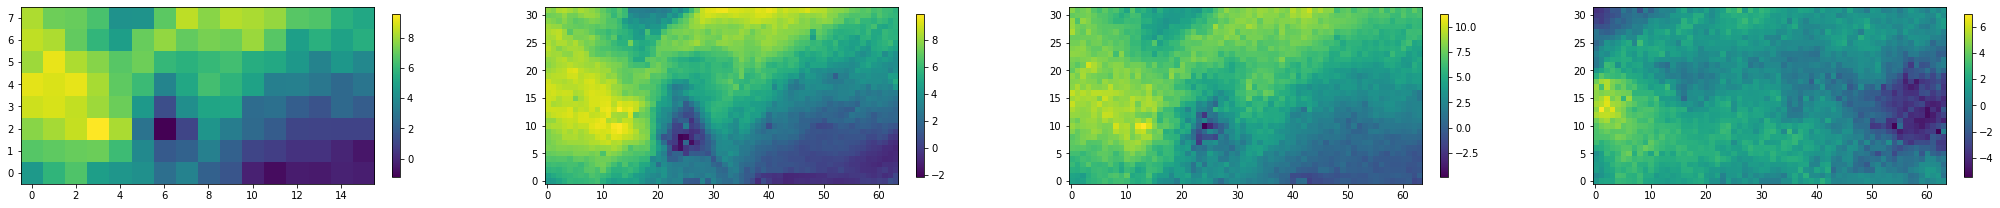

Fold 3/3
3300 training samples, 3300 test samples, 8x16 -> 32x64


train, epoch 1/20:   0%|          | 0/330 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [14]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 20
def rmse(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
def bias(y_true, y_pred):
    return tf.math.reduce_mean(y_pred - y_true, axis=[1,2,3])
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo, monthly_means_lo = remove_monthly_means(train_lo)
    train_hi, monthly_means_hi = remove_monthly_means(train_hi)
    test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
    test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size)
    #vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    encoder = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
#     model = VariationalModel(encoder, normal())
#     model.compile(optimizer=Adamax(lr=1.0E-4), output_shape=(None,wt_hi,ht_hi,1), metrics=[rmse,bias])
#     model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
#               validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
#     encoder.trainable = False
    flow_hr = Invert(GlowFlow(num_layers=4, depth=16, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    model = VariationalModel(encoder, normal(), flow_hr)
    model.compile(optimizer=Adamax(lr=1.0E-3), output_shape=(None, wt_hi, ht_hi, 1), metrics=[rmse, bias])
    model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
              validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    sample = model.sample(test_x, flatten_z=True)
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[1].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()